In [2]:
import re
import pandas as pd
import numpy as np
import torch
import umap
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from tqdm.notebook import tqdm
from collections import Counter
# from wordcloud import WordCloud
# from konlpy.tag import Okt $23
import matplotlib.font_manager as fm
import urllib.request

from urllib.parse import urlparse,parse_qs
import requests
from bs4 import BeautifulSoup
import json
import time
import datetime
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import unicodedata
import networkx as nx
from sklearn.manifold import MDS

<h1 style="margin:5px;">파이썬 데이터 분석- "탄핵" 키워드의 네이버 뉴스 댓글을 통한 각 언론사에서 나타나는 댓글의 특징과 감성분석</h1>
<h2>
<ul style="list-style-type: none">
    <li style="">202304305 정성현</li>
    <li style="">202104234 안성준</li>
    <li style="">202104241 여동수</li>
</ul>
</h2>
<hr>
<h2 style="margin:5px;" >차례</h2>
<h3>
<ol>
  <li> 들어가며</li>
  <li> 데이터 소개</li>
  <li> 데이터 수집 방법-크롤링</li>
  <li> 데이터 분석-댓글 작성자의 언론사 편향</li>
  <li> 데이터 분석- 댓글 작성 시간</li>
  <li> 데이터 분석- 감정 분석</li>
  <li> 데이터 분석-</li>
  <li> 결론 </li>
  <li> 마치며 </li>
</ol>
<h3>


<h2> 1. 들어가며 </h2>

<p><img src="./notebook_img/EAI_2025_1.png" alt="이미지 오류">
<img src="./notebook_img/EAI_2025_2.png" alt="이미지 오류">
</p>






<h2> 2.데이터 소개 </h2>

성공: 나경원 "한동훈, 도저히 같이 할 수 없는 후보…탄핵 선동" , https://n.news.naver.com/article/015/0005118778?sid=100 , 2025-04-14 , 성공: 1939 실패: 32 총 댓글 개수: 731294


In [3]:
before_integrated=pd.read_csv("../src/news_comments/JTBC/2024-12-09_JTBC_김상욱 _탄핵 찬성..논의 중인 의원들 있어, 탄핵안 통과 충분_.csv")

In [4]:
before_integrated.head(5)

,user_nickname,userIdNo,comments,visible,replyLevel,regTime,parentCommentNo,sympathyCount,antipathyCount,replyAllCount
0,kang****,2uUqJ,김상욱 의원님 화이팅 입니다. 힘내세요. 국민들이 기억할 것 입니다.,True,1,2024-12-10T10:38:22+0900,845152822566584479,1270,38,21
1,gsy7****,NaN,NaN,False,1,2024-12-10T10:38:06+0900,845152805487378484,0,0,16
2,hyun****,4nbAN,다행이다 젊은 보수가 있다는게 \n응원합니다 그래야 보수가 살수있어요\n견제도 할수...,True,1,2024-12-10T10:38:37+0900,845152838974701852,328,10,3
3,syki****,59jX,이래야 국회의원이라할수있지.. 객관적이고 이성적인 판단에 박수를 보냅니다,True,1,2024-12-10T10:39:28+0900,845152893114777828,219,6,3
4,anto****,2mW3x,머털도사와 108요괴라는 만화가 있다 거기서 108요괴가 어떻게 퇴치되는지 보면 저...,True,1,2024-12-10T10:38:48+0900,845152850064441741,105,2,6


In [5]:
df=pd.read_csv("../src/integrated_csv/integrated_csv.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731294 entries, 0 to 731293
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   press_name       731191 non-null  object
 1   date             731294 non-null  object
 2   user_nickname    731294 non-null  object
 3   userIdNo         575498 non-null  object
 4   comments         575498 non-null  object
 5   visible          731294 non-null  bool  
 6   replyLevel       731294 non-null  int64 
 7   regTime          731294 non-null  object
 8   parentCommentNo  731294 non-null  int64 
 9   sympathyCount    731294 non-null  int64 
 10  antipathyCount   731294 non-null  int64 
 11  replyAllCount    731294 non-null  int64 
dtypes: bool(1), int64(5), object(6)
memory usage: 62.1+ MB


In [7]:
df.query("press_name.isna()")

,press_name,date,user_nickname,userIdNo,comments,visible,replyLevel,regTime,parentCommentNo,sympathyCount,antipathyCount,replyAllCount
660378,NaN,2025-04-10,kcyn****,kE4J,법꾸러지들.\n전직대통령들은전부.포토라인섰다.\n탄핵된주제에.\n대통령대우냐,True,1,2025-04-11T14:08:14+0900,856484440472289376,136,9,5
660379,NaN,2025-04-10,tele****,1zZa0,누구한테는 절대 안된다고 기자들 앞에서 전국민에게 개망신을 주어 결국 자살하게 만들...,True,1,2025-04-11T14:10:30+0900,856484587222597838,103,1,1
660380,NaN,2025-04-10,xinz****,2cw9SF,무슨특해냐.출석하면 법정구속해야지!,True,1,2025-04-11T14:15:45+0900,856484924864069893,35,4,2
660381,NaN,2025-04-10,choj****,GxDv,지하주차장으로 곧 들어가게 될 것니다. \n구속이 되면 자동으로 호송차대절해서 법원...,True,1,2025-04-11T15:12:15+0900,856488565016625251,30,1,0
660382,NaN,2025-04-10,dyhw****,9sk0Q,바퀴벌레는 어둡고 습한데를 좋아해요,True,1,2025-04-11T14:17:09+0900,856485014706061382,28,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
660476,NaN,2025-04-10,baek****,bJ1gy,빨리 사형선고하고 집행해라!!!,True,1,2025-04-11T23:15:08+0900,856519674739818544,0,1,0
660477,NaN,2025-04-10,rnjs****,3Ythr,이인간은 뭔데 다 특혜냐 이러니 저 정신없는 인간들이 왕인줄알고 설치잖아 법앞에 모...,True,1,2025-04-11T15:03:28+0900,856487999037243594,0,1,0
660478,NaN,2025-04-10,3259****,ckKf0,그렇게 요청해 달라고 간청하는 거냐? \n납짝 엎드려 하는 짓이 부끄럽지도 않나?,True,1,2025-04-11T14:14:42+0900,856484857469993204,0,1,0
660479,NaN,2025-04-10,deri****,3eqzu,홧팅 윤통 꼭명예 회복하세요,True,1,2025-04-11T18:56:53+0900,856503036489498881,0,2,0


In [8]:
df=df.query("press_name.notna()")

In [9]:
df.query("press_name.isna()")

,press_name,date,user_nickname,userIdNo,comments,visible,replyLevel,regTime,parentCommentNo,sympathyCount,antipathyCount,replyAllCount


In [10]:
df.query('visible == False').head(1)

,press_name,date,user_nickname,userIdNo,comments,visible,replyLevel,regTime,parentCommentNo,sympathyCount,antipathyCount,replyAllCount
11,중앙일보,2025-01-09,dewy****,NaN,NaN,False,1,2025-01-09T17:37:14+0900,847962946872016996,0,0,0


In [11]:
df.head()

,press_name,date,user_nickname,userIdNo,comments,visible,replyLevel,regTime,parentCommentNo,sympathyCount,antipathyCount,replyAllCount
0,중앙일보,2025-01-09,seki****,6boTo,"여론에는 흔들리지 않겠지만, 전라도 민주당의 지침을 따를 거면서,,,,걸래같은 것들...",True,1,2025-01-09T16:22:50+0900,847958153520742764,154,23,14
1,중앙일보,2025-01-09,lafa****,ddbVw,헌재가 수사 기록을 송부받은 것은 내란죄를 빼고 심리 하겠다는 것입니다. 지금 헌재...,True,1,2025-01-09T16:18:07+0900,847957849668583484,70,14,5
2,중앙일보,2025-01-09,dean****,1CqXM,헌재 탄핵심판은 180일 이내에 결론내면 된다. 왜 이렇게 심리 속도가 느리냐고 따...,True,1,2025-01-09T16:24:48+0900,847958280071283034,55,11,4
3,중앙일보,2025-01-09,alfn****,4GZw0,"이재명 대표의 재판은 너무 이례적이게 늦는거 같고, 민주당이 신청한 국무위원들의 탄...",True,1,2025-01-09T16:27:23+0900,847958446803255471,40,1,0
4,중앙일보,2025-01-09,th******,Drxg,이재명 재판하고 비교해보면 양심이 흔들릴거다...,True,1,2025-01-09T16:24:31+0900,847958261297578225,21,3,1


In [12]:
df['comments'].notnull().sum() + df.query('visible == False').shape[0]

731191

In [13]:
df.describe(
    include="object"
)

,press_name,date,user_nickname,userIdNo,comments,regTime
count,731191,731191,731191,575403,575403,731191
unique,57,132,84110,187527,513518,615809
top,연합뉴스,2024-12-27,park****,3leoB,응원합니다,2024-12-27T11:38:02+0900
freq,185404,19742,2262,147,125,11


In [14]:
df['press_name'].value_counts().describe()

count        57.000000
mean      12827.912281
std       28406.543492
min           3.000000
25%         283.000000
50%        4348.000000
75%       12994.000000
max      185404.000000
Name: count, dtype: float64

In [15]:
top_press_names = df['press_name'].value_counts().head(22).index

In [16]:
top_press_names

Index(['연합뉴스', '조선일보', '한겨레', '뉴시스', 'MBC', '경향신문',
       '중앙일보', '동아일보', 'SBS', 'JTBC', '오마이뉴스', 'KBS',
       '한국경제', 'TV조선', '문화일보', 'YTN', '뉴스1', '매일경제',
       '국민일보', 'MBN', '이데일리', '세계일보'],
      dtype='object', name='press_name')

In [17]:
df = df[df['press_name'].isin(top_press_names)]

<h2> 3. 크롤링 </h2>


In [17]:

# 사용자 에이전트 정의
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36'
}
crawling_succ_count=0
crawling_fail_count=0
total_crawling_comment=0

# 뉴스 URL 수집 함수
def news_url(query, date1) -> tuple[list, list, datetime.date]:
    page = 1
    url_list = []
    title_list = []
    link_set = set()
    one_day = datetime.timedelta(days=1)
    date2= date1+ one_day
    date1_str= str(date1).replace("-", ".")
    date2_str=str(date2).replace("-", ".")
    date1_str_not_separated= str(date1).replace("-", "")
    date2_str_not_separated= str(date2).replace("-", "")



    while page <= 150:
        #url에 대해
        # url = (
        #         "https://m.search.naver.com/search.naver?where=m_news&sm=tab_pge&query="
        #         + query +
        #         "&sort=0&photo=0&field=0&pd=1&ds=&de=&cluster_rank=129&mynews=0&office_type=0"
        #         "&office_section_code=0&news_office_checked=&nso=so:r,p:1w,a:all&start=" + str(page) #start은 최소 1 최대 1000임
        # )
        url= (
                "https://m.search.naver.com/search.naver?ssc=tab.m_news.all&query="
                + query + "&sm=mtb_opt&sort=0&photo=0&field=0&pd=3&ds="
                + date1_str + "&de=" + date2_str + "&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom"
                + date1_str_not_separated + "to" + date1_str_not_separated + "&is_sug_officeid=0&office_category=0&service_area=0" + str(page)
        )
        headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
            'referer':url
        }

        response = requests.get(url, headers=headers)
        html = response.text
        soup = BeautifulSoup(html, "lxml")
        # atags = soup.select('.news_tit')
        #위에 atags=soup.select('.news_tit')은 위 response로 받아온 html에서 뉴스 링크가 있는 a태그에 있는 클래스였는데 4/28일 확인해보니까
        #이부분이 암호화 되어서 이 코드가 더 이상 유효하지 않는거 같습니다.
        atags = soup.select('._AuHeQ05X7PwSlhb6H2B') #처럼 암호화 된 부분을 확인해서 넣으면 작동하긴 하는데 이게 나중에 어떻게 변할지 모르겠습니다.
        print(atags)
        for i in atags:
            if "https://n.news.naver.com/" in i['href']:
                url_list.append(i['href'])
                news_title_name=get_title_name(i)
                title_list.append(news_title_name)
        if len(atags) < 15:
            break
        # page += 15
        page+= 150
        time.sleep(0.5)

    return url_list ,title_list, date1  #zip으로 묶거나 받는 변수를 2개 나 튜플로 해야함

<img src="./notebook_img/naver_news.png">

In [44]:

#언론사 id(oid_2)를 언론사 이름으로 바꾸는 함수  ex) "023" -> "연합뉴스"
# html요청 없이 따로 딕셔너리 형태로 만들어서 사용하면  더 빨라지는데 언론사 수가 생각보다 많아서 그냥 이렇게 했습니다.
def get_press_name(press_id):
    url_company='https://news.naver.com/main/officeList.naver'
    html_company = urllib.request.urlopen(url_company).read()
    soup_company = BeautifulSoup(html_company, "lxml")
    title_company=soup_company.find_all(class_='list_press nclicks(\'rig.renws2pname\')')
    for i in title_company:
        parts= urlparse(i.attrs['href'])
        if parse_qs(parts.query)['officeId'][0]==press_id:
            news_name = i.text.strip()
            return news_name


# 뉴스 이름을 html에서 가져오는 함수- news_url 함수 안에서 사용해서 별도의 html요청 없이 링크를 가져오려고 하는 html에서 추출
def get_title_name(atag):
    news_title_name=atag.find('span').text.strip()
    print(news_title_name) #가져 오는 뉴스 이름 확인용
    return news_title_name



# 댓글 수집 함수
def comment(url_list,news_title_list, news_date):
    global crawling_succ_count
    global crawling_fail_count
    global total_crawling_comment
    url_total_num= len(url_list)
    url_list_num=0
    news_title_list_num=0
    total_comment = [];user_nickname=[];comments=[];userIdNo=[];visible=[];replyLevel=[];regTime=[];parentCommentNo=[];sympathyCount=[];antipathyCount=[];replyAllCount=[]
    # following=[]
    for url_ex in url_list:
        url = url_ex.split('?')[0]
        oid_1 = url.split('/')[-1]
        oid_2 = url.split('/')[-2]
        print(news_title_list[news_title_list_num],url_list[url_list_num])
        i = 1

        while True:
            params = {
                'ticket': 'news',
                'templateId': 'default_society',
                'pool': 'cbox5',
                'lang': 'ko',
                'country': 'KR',
                'objectId': f'news{oid_2},{oid_1}',
                'pageSize': '100',
                'indexSize': '10',
                'page': str(i),
                'currentPage': '0',
                'moreParam.direction': 'next',
                'moreParam.prev': '',
                'moreParam.next': '',
                'followSize': '100',
                'includeAllStatus': 'true',
            }
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
                'referer': url_ex
            }
            response = requests.get(
                'https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json',
                params=params,
                headers=headers
            )

            response.encoding = "UTF-8-sig"
            res = response.text.replace("_callback(", "")[:-2]


            try:
                temp = json.loads(res)
                comment_list = temp['result'].get('commentList', [])
                total_crawling_comment+=len(comment_list)
                if not comment_list:
                    print("comment 가져오기 실패")
                    crawling_fail_count+=1
                    log_text(
                        news_title_list[news_title_list_num],
                        url_list[url_list_num],
                        news_date,crawling_succ_count,
                        crawling_fail_count,
                        total_crawling_comment,
                        2)
                    url_list_num += 1
                    news_title_list_num += 1
                    break
                #아래는 가져온 comment_list( 위에서 요청한 json 내용 으로 'contents': '탄해반대집회는~~' 형태로 존재)

                # if ((not user_nickname) and (not comments)):
                #     user_nickname = [k['userName'] for k in comment_list]  # json 내용에서 userName에 해당하는 부분을 가져와 리스트로 저장시킴
                #     comments = [c['contents'] for c in comment_list]  # json에서 contents에 해당하는 부분을 가져와 리스트로 저장시킴
                #     # hiddenByCleanbot= [a['hiddenByCleanbot'] for a in comment_list]
                #     userIdNo=[b['userIdNo'] for b in comment_list]
                #     visible= [c1['visible'] for c1 in comment_list]
                #     replyLevel=[d['replyLevel'] for d in comment_list]
                #     regTime=[e['regTime'] for e in comment_list]
                #     parentCommentNo=[f['parentCommentNo'] for f in comment_list]
                #     sympathyCount= [g['sympathyCount'] for g in comment_list]
                #     antipathyCount=[h['antipathyCount'] for h in comment_list]
                #     # following=[p['following'] for p in comment_list]
                #     replyAllCount=[r['replyAllCount'] for r in comment_list]
                #
                #
                #
                # else:
                #     user_nickname.extend([k['userName'] for k in comment_list])
                #     comments.extend([c['contents'] for c in comment_list])
                #     # hiddenByCleanbot.extend= [a['hiddenByCleanbot'] for a in comment_list]
                #     userIdNo.extend([b['userIdNo'] for b in comment_list])
                #     visible.extend([c['visible'] for c in comment_list])
                #     replyLevel.extend([d['replyLevel'] for d in comment_list])
                #     regTime.extend([e['regTime'] for e in comment_list])
                #     parentCommentNo.extend([f['parentCommentNo'] for f in comment_list])
                #     sympathyCount.extend ([g['sympathyCount'] for g in comment_list])
                #     antipathyCount.extend([h['antipathyCount'] for h in comment_list])
                #     # following.extend([p['following'] for p in comment_list])
                #     replyAllCount.extend(r['replyAllCount'] for r in comment_list)
                if not user_nickname and not comments:
                    user_nickname = []
                    comments = []
                    userIdNo = []
                    visible = []
                    replyLevel = []
                    regTime = []
                    parentCommentNo = []
                    sympathyCount = []
                    antipathyCount = []
                    replyAllCount = []
                for item in comment_list:
                    user_nickname.append(item['userName'])
                    comments.append(item['contents'])
                    userIdNo.append(item['userIdNo'])
                    visible.append(item['visible'])
                    replyLevel.append(item['replyLevel'])
                    regTime.append(item['regTime'])
                    parentCommentNo.append(item['parentCommentNo'])
                    sympathyCount.append(item['sympathyCount'])
                    antipathyCount.append(item['antipathyCount'])
                    replyAllCount.append(item['replyAllCount'])


                if len(comment_list) < 100:
                    #total_comment.extend(comments) #없어도 되는 코드 gptexample에 있던 코드
                    comment_list_sum=list(
                        zip(
                            user_nickname,
                            userIdNo,
                            comments,
                            visible,
                            replyLevel,
                            regTime,
                            parentCommentNo,
                            sympathyCount,
                            antipathyCount,
                            replyAllCount
                        )
                    ) #df로 저장하기 위해 묶어줌
                    col=['user_nickname','userIdNo','comments','visible','replyLevel','regTime','parentCommentNo','sympathyCount','antipathyCount','replyAllCount']
                    df=pd.DataFrame(comment_list_sum, columns=col) # columns를 작성자, 내용 으로 가지는 df생성
                    #파일을 저장하기 위한 경로 이름 생성, 파일 이름 생성
                    news_name=get_press_name(oid_2) #언론사 id를 언론사 이름 str로 바꾸는 함수
                    BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
                    folder_path = os.path.join(BASE_DIR, "src", "news_comments",news_name)
                    # folder_path= f'../src/news_comments/{news_name}'
                    # folder_path=f'./{news_name}'
                    os.makedirs(folder_path, exist_ok=True) #이 py가 있는 경로에 "언론사이름"을 이름으로 하는 폴더 생성, 존재시 넘어감
                    # print(news_title_list_num)

                    if news_title_list_num >= len(news_title_list):
                        print(f"news_title_list_num{news_title_list_num}이 news_title_list {len(news_title_list)}길이를 초과했습니다.")
                        url_list_num += 1
                        news_title_list_num += 1
                        # url_list_num = 0
                        # news_title_list_num = 0
                        break
                    newstitle_regex= re.sub(r'[\\/*?:"<>|]', '_',news_title_list[news_title_list_num])
                    file_name= f"{news_date}_{news_name}_{newstitle_regex}.csv"
                    folder_file_path= os.path.join(folder_path, file_name)
                    #파일 이름을 언론사_뉴스제목 으로 정의
                    # if os.path.exists(f"{folder_path}/{file_name}"): #같은 이름 존재시 break
                    #     print(f"{folder_path}/{file_name} 이미 존재함. ")

                    if os.path.exists(folder_file_path):
                        print(f"{folder_file_path} 이미 존재함.")
                        log_text(
                            news_title_list[news_title_list_num],
                            url_list[url_list_num],
                            news_date,
                            crawling_succ_count,
                            crawling_fail_count,
                            total_crawling_comment,
                            3
                        )
                        url_list_num += 1
                        news_title_list_num += 1
                        continue
                    df.to_csv(f"{folder_path}/{file_name}", index=False)
                    comment_list_sum = []
                    comments=[]
                    user_nickname= []
                    # hiddenByCleanbot= []
                    userIdNo=[];visible= []
                    replyLevel=[];regTime=[];replyAllCount=[]
                    parentCommentNo=[];sympathyCount=[];antipathyCount=[];following=[]

                    print(f"\n{news_date}: {news_title_list_num+1}/{url_total_num}")
                    crawling_succ_count+=1
                    print(f'성공: {crawling_succ_count} 실패: {crawling_fail_count}')
                    log_text(
                        news_title_list[news_title_list_num],
                        url_list[url_list_num],
                        news_date,
                        crawling_succ_count,
                        crawling_fail_count,
                        total_crawling_comment,
                        1
                        )
                    url_list_num += 1
                    news_title_list_num += 1
                    break
                else:
                    i += 1 # params= ..., 'page'=str(i),...에서  pageSize=100은 한 페이지당 불러올 댓글 최대가 100이기 떄문에 다음페이지로
                    #넘겨야함 즉 i 값 증가시켜서 다음 페이지 댓글 최대 100개를 불러옴
                    time.sleep(0.3)
            except Exception as e:
                print(f"[에러 발생] {url_ex}: {e}")
                break
            finally:
                print('|',end="")

    return total_comment #필요 없음
def log_text(news_url,news_title,news_date,succ_count,fail_count,total_crawling_comment,current_status):
    base_dir= os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    target_path= os.path.join(base_dir, "src", "news_comments", "into.txt")
    if (current_status==1):
        with open(target_path, 'a', encoding='utf-8') as file:
            file.write(f'성공: {news_url} , {news_title} , {news_date} , 성공: {succ_count} 실패: {fail_count} 총 댓글 개수: {total_crawling_comment}\n')
    elif  (current_status==2):
        with open(target_path, 'a', encoding='utf-8') as file:
            file.write( f'실패: {news_url} , {news_title} , {news_date} , 성공: {succ_count} 실패: {fail_count} 총 댓글 개수: {total_crawling_comment}\n')
    elif(current_status==3):
        with open(target_path, 'a', encoding='utf-8') as file:
            file.write( f'중복: {news_url} , {news_title} , {news_date} , 성공: {succ_count} 실패: {fail_count} 총 댓글 개수: {total_crawling_comment}\n')

query = "윤석열 탄핵"  # 원하는 검색어
encoded_query = urllib.parse.quote(query) #url에 쿼리스트링에 한글 사용하려면 인코딩 필수
date= datetime.date(2024, 12, 4)
while(date< datetime.date(2025, 4, 15)):
    news_links, news_title ,news_date= news_url(encoded_query, date)
    print(f"{date} 뉴스 url 수집 완료")
    comment(news_links, news_title, news_date)
    print(news_links)
    date= date+ datetime.timedelta(days=1)

992

<img src="./notebook_img/explain_code.jpeg" width=720 height=360>

In [ ]:
target_path= "../src/news_comments"
folders=[
    name for name in os.listdir(target_path)
    if os.path.isdir(os.path.join(target_path))
]
print(folders)
df_all=pd.DataFrame()
count=0
for folder in folders:
    path=f"../{target_path}/{folder}"
    try:
        in_folder= [
        name for name in os.listdir(path)
        if os.path.isdir(os.path.join(path))
        ]
        print(in_folder)
        print(f"{folder}: {len(in_folder)}")
    except NotADirectoryError as e:
        continue
    for csv_name in in_folder:
        count+=1
        try:
            date=re.findall(r"\d{4}-\d{2}-\d{2}",csv_name)[0]
            df_read = pd.read_csv(f"{path}/{csv_name}")
            df_read.insert(0, "date", date)
            df_read.insert(0, "press_name", folder)
            df_all = pd.concat([df_all, df_read])
            print(f"{count} \n {folder}-{csv_name} 통합 완료 ")
            with open("./log_integrating_csv4_all.txt", "a") as file:
                file.write(f"{count}{in_folder}-{csv_name} 통합 완료 \n")
        except IndexError as e:
            print(e)
df_all.to_csv(f"../src/integrated_csv/integrated_csv.csv",index=False)

<h2> 4.데이터 분석-댓글 작성자의 언론사 편향</h2>



In [18]:
dup_userIdNo=df['userIdNo'].value_counts()
dup_userIdNo=dup_userIdNo[dup_userIdNo>=2].index
df_dup=df[df['userIdNo'].isin(dup_userIdNo)]

In [19]:
df_dup[['press_name','user_nickname','userIdNo','comments','regTime']].sort_values(by=['userIdNo'] ,ascending=False)

,press_name,user_nickname,userIdNo,comments,regTime
669284,뉴스1,kukd****,zza4,아직 살아있노 ㅋㅋㅋㅋㅋ\n쥐쌔끼,2025-02-17T17:34:07+0900
269923,이데일리,kukd****,zza4,살아있었네 ㅋㅋㅋ,2025-01-27T20:07:12+0900
264507,이데일리,kukd****,zza4,살아있었네 ㅋㅋㅋ,2025-01-27T20:07:12+0900
288908,조선일보,aemy****,zzUc,여기 2찍들도 우냐 ㅋㅋㅋㅋㅋ,2025-04-04T11:31:18+0900
282835,조선일보,aemy****,zzUc,여기 2찍들도 우냐 ㅋㅋㅋㅋㅋ,2025-04-04T11:31:18+0900
...,...,...,...,...,...
522425,연합뉴스,dwpm****,100Xr,"이제 그만 징징대라,",2025-01-29T16:12:19+0900
266778,이데일리,kdy9****,100Il,이 놈부터 잡아 쳐 넣어야 하는데 하나같이 말도 안되는 소리만 하는건지.,2025-04-15T09:49:19+0900
593763,한겨레,kdy9****,100Il,몇가지 말고 안되는 이유중 민주당이 일방적이라고 계엄을 할 수 있는 이유라고 생각하...,2025-03-12T13:50:35+0900
51751,JTBC,kdw8****,1001o,앞뒤가 안맞아요 앞뒤좀 생각해요 석렬이형,2025-02-06T16:27:28+0900


In [20]:
df_count_dup=(
    df_dup.groupby("userIdNo")["press_name"]
            .value_counts()
            .reset_index(name='count')
)

In [21]:
df_count_dup

,userIdNo,press_name,count
0,1001o,JTBC,2
1,100Il,이데일리,1
2,100Il,한겨레,1
3,100Xr,연합뉴스,2
4,100n7,MBC,1
...,...,...,...
231058,zzO1,연합뉴스,2
231059,zzO1,동아일보,1
231060,zzUc,조선일보,2
231061,zza4,이데일리,2


In [22]:
df_pivot=pd.pivot_table(df_count_dup,columns='press_name',index='userIdNo',values='count',fill_value=0)

In [23]:
df_pivot

press_name,JTBC,KBS,MBC,MBN,SBS,TV조선,YTN,경향신문,국민일보,뉴스1,...,매일경제,문화일보,세계일보,연합뉴스,오마이뉴스,이데일리,조선일보,중앙일보,한겨레,한국경제
userIdNo,,,,,,,,,,,,,,,,,,,,,
1001o,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100Il,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
100Xr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
100n7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100zL,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zykt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
zzO1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_pivot.sum(axis=1).describe(
    percentiles=[0.75,0.9,0.95,  0.99]
)

count    94425.000000
mean         4.753487
std          4.880030
min          2.000000
50%          3.000000
75%          5.000000
90%         10.000000
95%         13.000000
99%         25.000000
max        146.000000
dtype: float64

In [25]:
percentage75=df_pivot.sum(axis=1).describe()['75%']
df_pivot2=df_pivot.loc[df_pivot.sum(axis=1)>percentage75,:]

In [26]:
df_pivot2

press_name,JTBC,KBS,MBC,MBN,SBS,TV조선,YTN,경향신문,국민일보,뉴스1,...,매일경제,문화일보,세계일보,연합뉴스,오마이뉴스,이데일리,조선일보,중앙일보,한겨레,한국경제
userIdNo,,,,,,,,,,,,,,,,,,,,,
101P9,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1029P,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
102A8,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,1.0,4.0,1.0,0.0,0.0
102Ps,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
102Xd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zw4x,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
zwFC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
zy4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,2.0,4.0,0.0,0.0


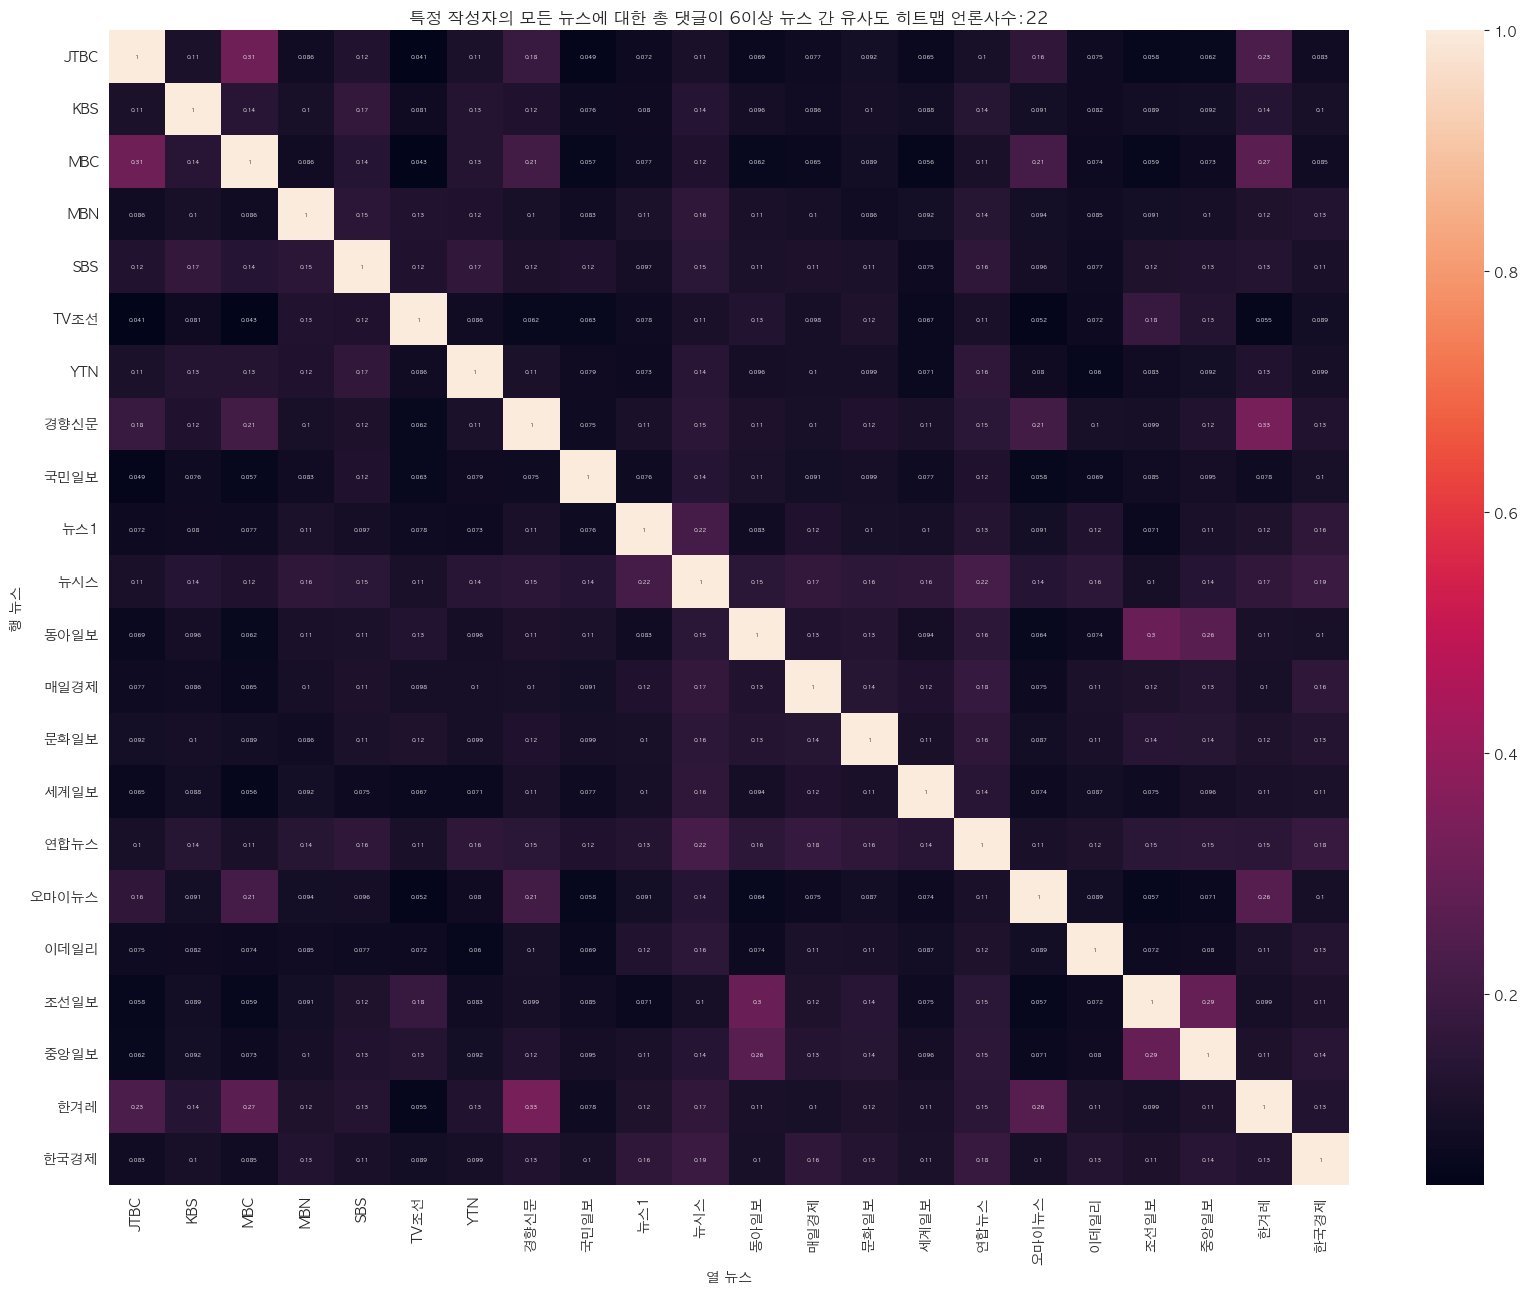

In [27]:

total_press_counts= len(df_pivot2.columns)
similarity_matrix = pd.DataFrame(
cosine_similarity(df_pivot2.T),
index=df_pivot2.columns,
columns=df_pivot2.columns
)
plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(20, 15))
labels = df_pivot2.columns
labels = [unicodedata.normalize('NFC', label) for label in labels]
sns.heatmap(similarity_matrix, cmap="rocket"
            , xticklabels=labels, yticklabels=labels, annot=True,annot_kws={"size": 4})

plt.title(f"특정 작성자의 모든 뉴스에 대한 총 댓글이 6이상 뉴스 간 유사도 히트맵 언론사수:{total_press_counts}")
plt.xlabel("열 뉴스")
plt.ylabel("행 뉴스")
plt.show()

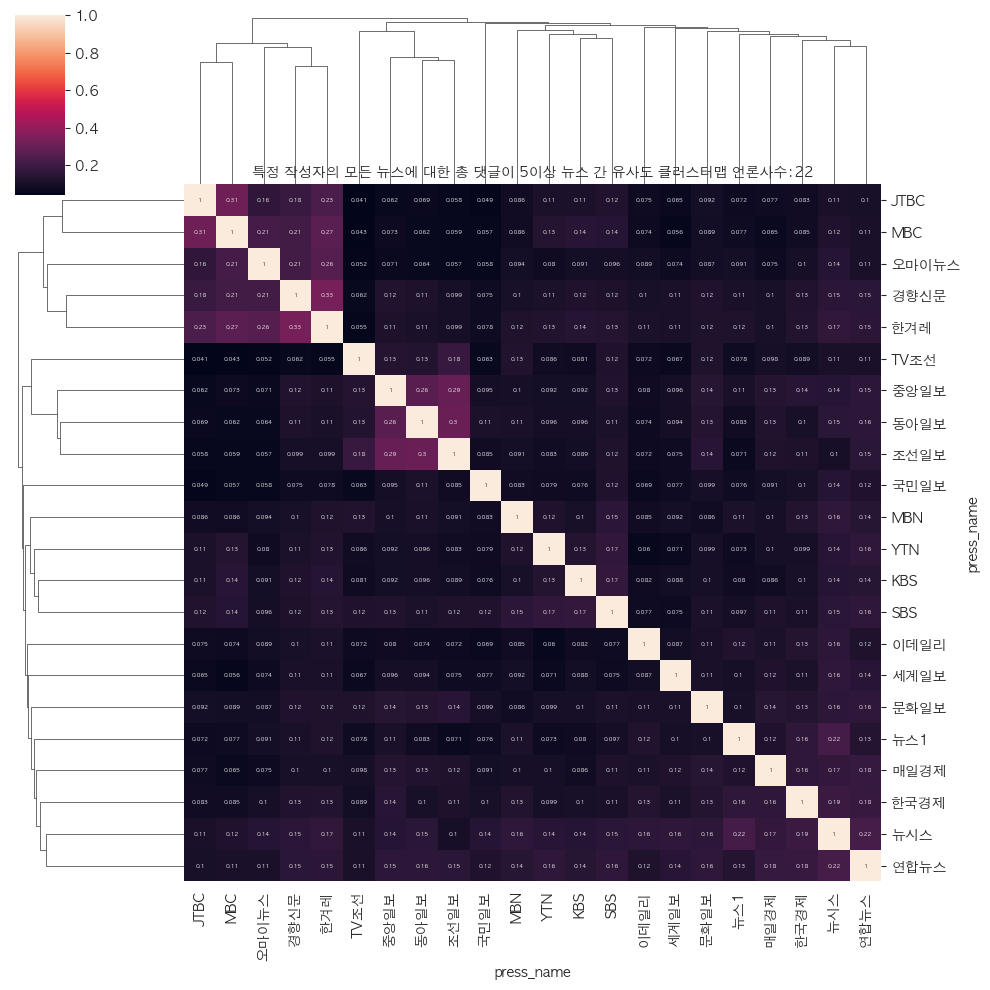

In [28]:
total_press_counts= len(df_pivot2.columns)
similarity_matrix = pd.DataFrame(
cosine_similarity(df_pivot2.T),
index=df_pivot2.columns,
columns=df_pivot2.columns
)
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

plt.rcParams['font.family'] = font_name
labels = df_pivot2.columns
labels = [unicodedata.normalize('NFC', label) for label in labels]
cluster = sns.clustermap(similarity_matrix, cmap="rocket", annot=True,annot_kws={"size": 4}, figsize=(10, 10),xticklabels=labels, yticklabels=labels)
cluster.ax_heatmap.set_title(f"특정 작성자의 모든 뉴스에 대한 총 댓글이 5이상 뉴스 간 유사도 클러스터맵 언론사수:{total_press_counts}", fontproperties=font_prop)

plt.show()

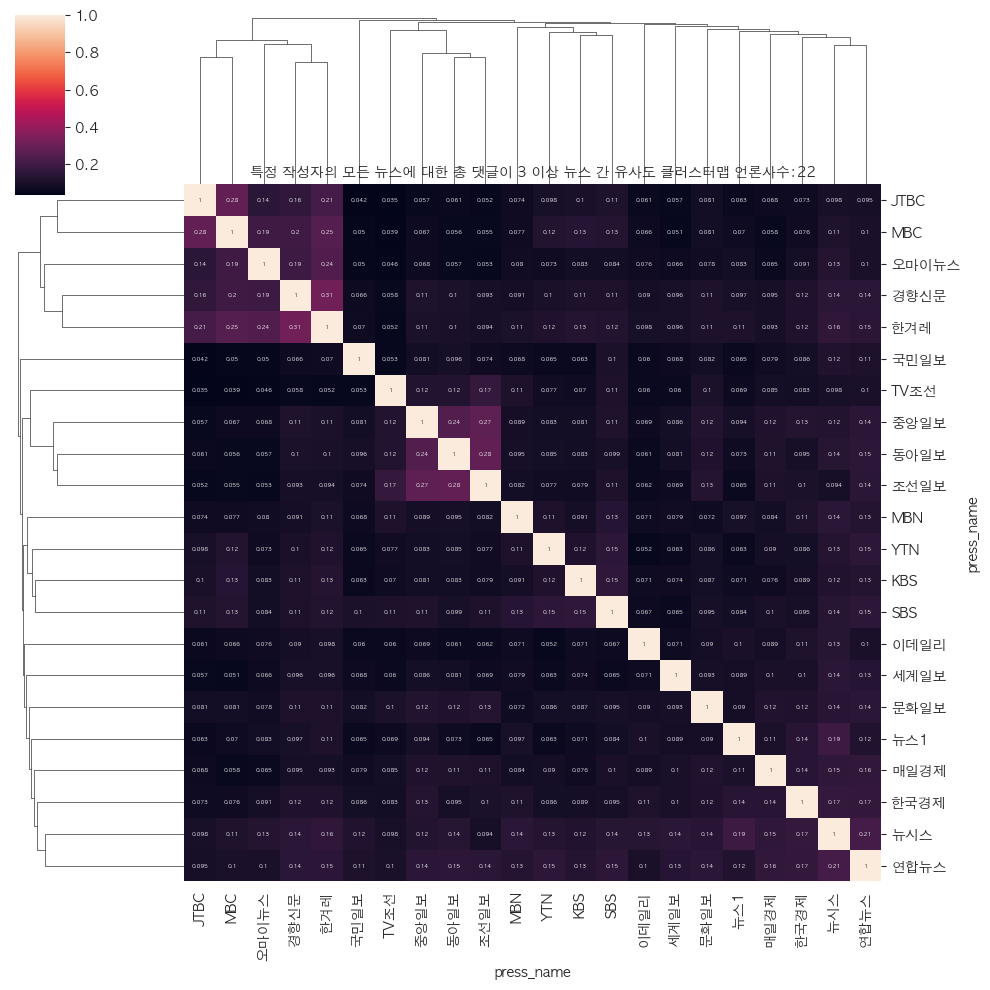

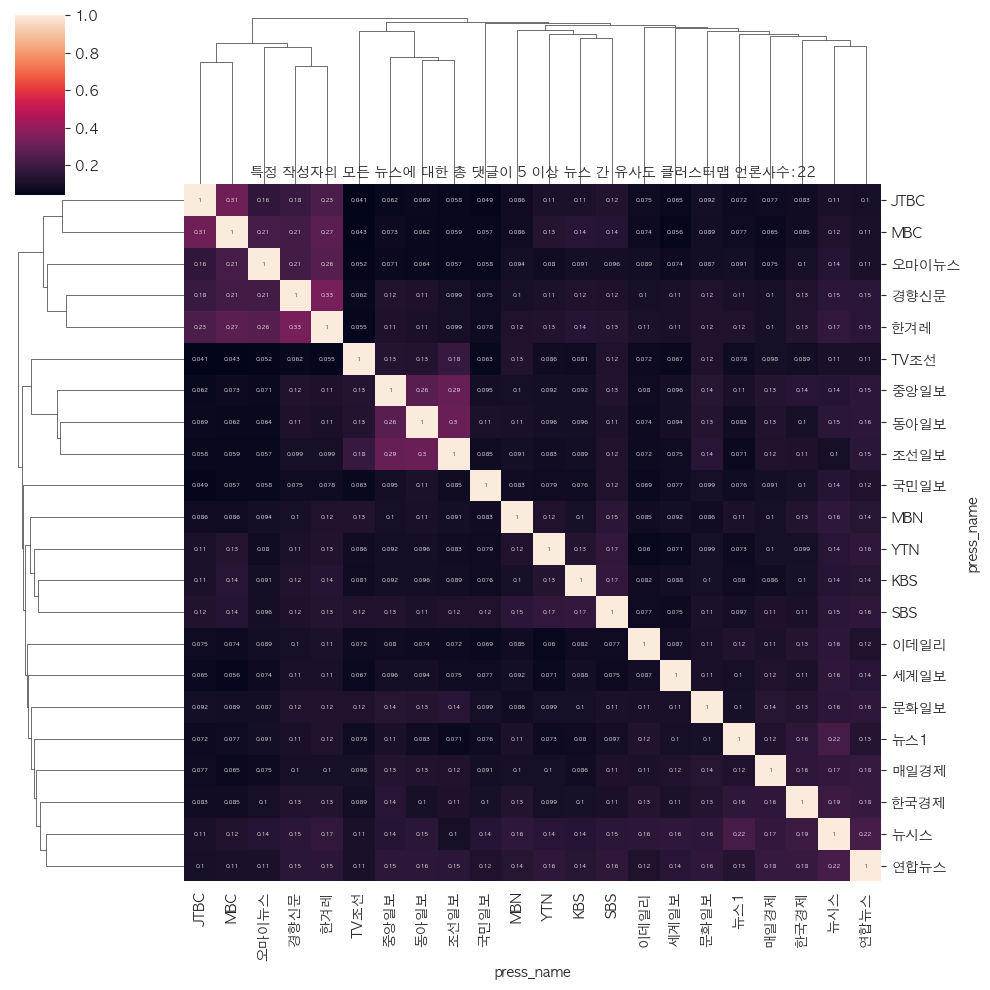

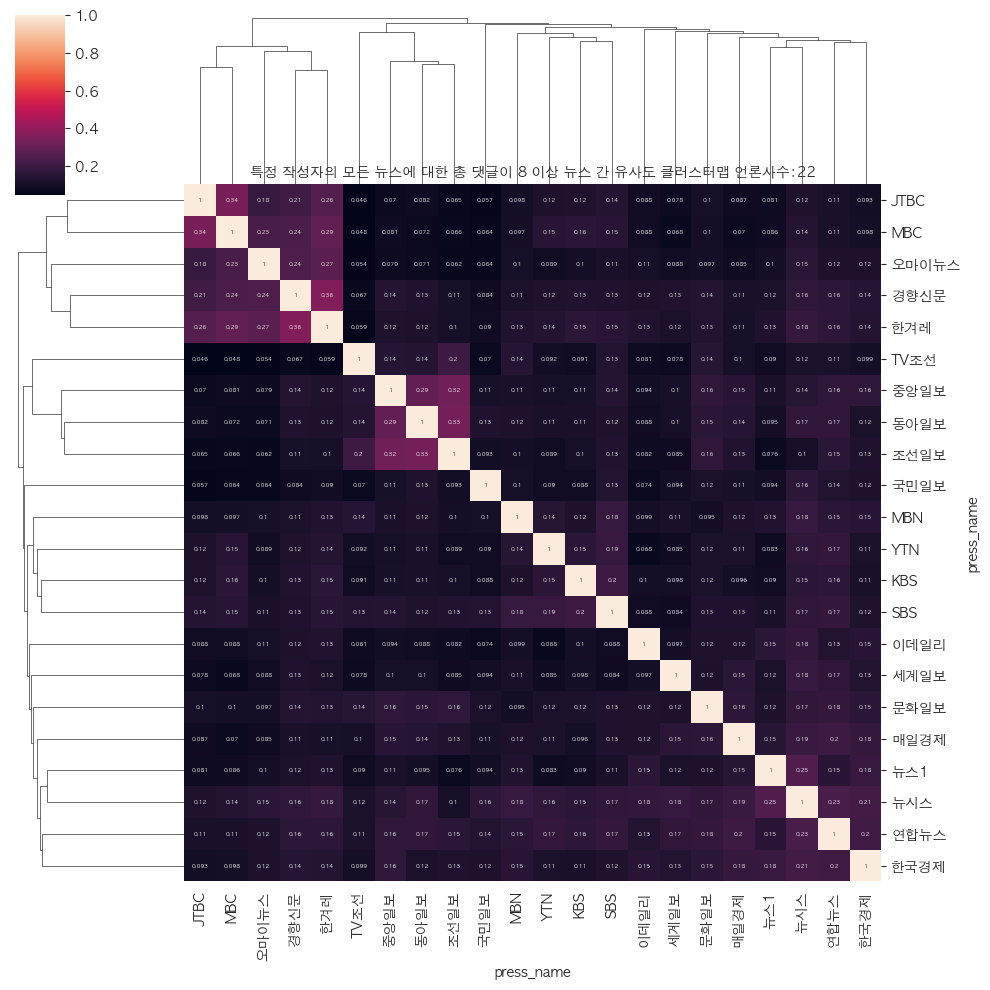

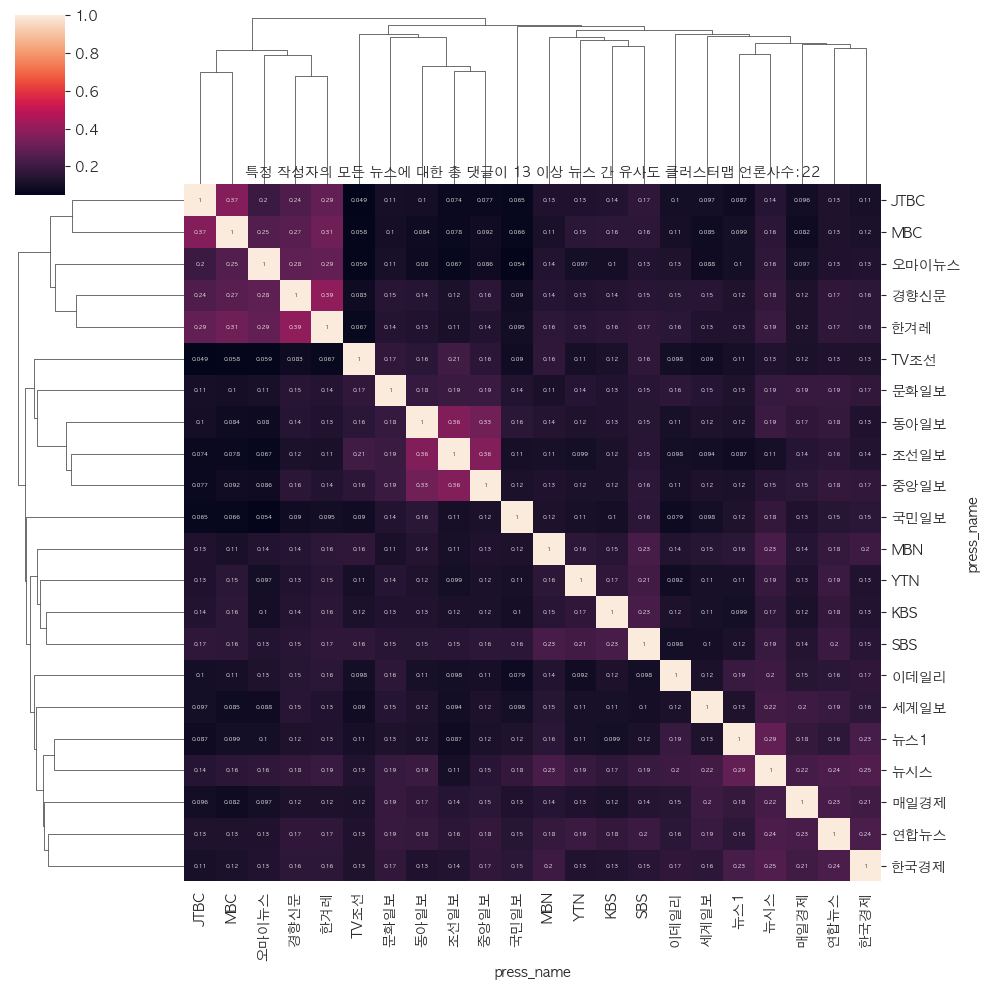

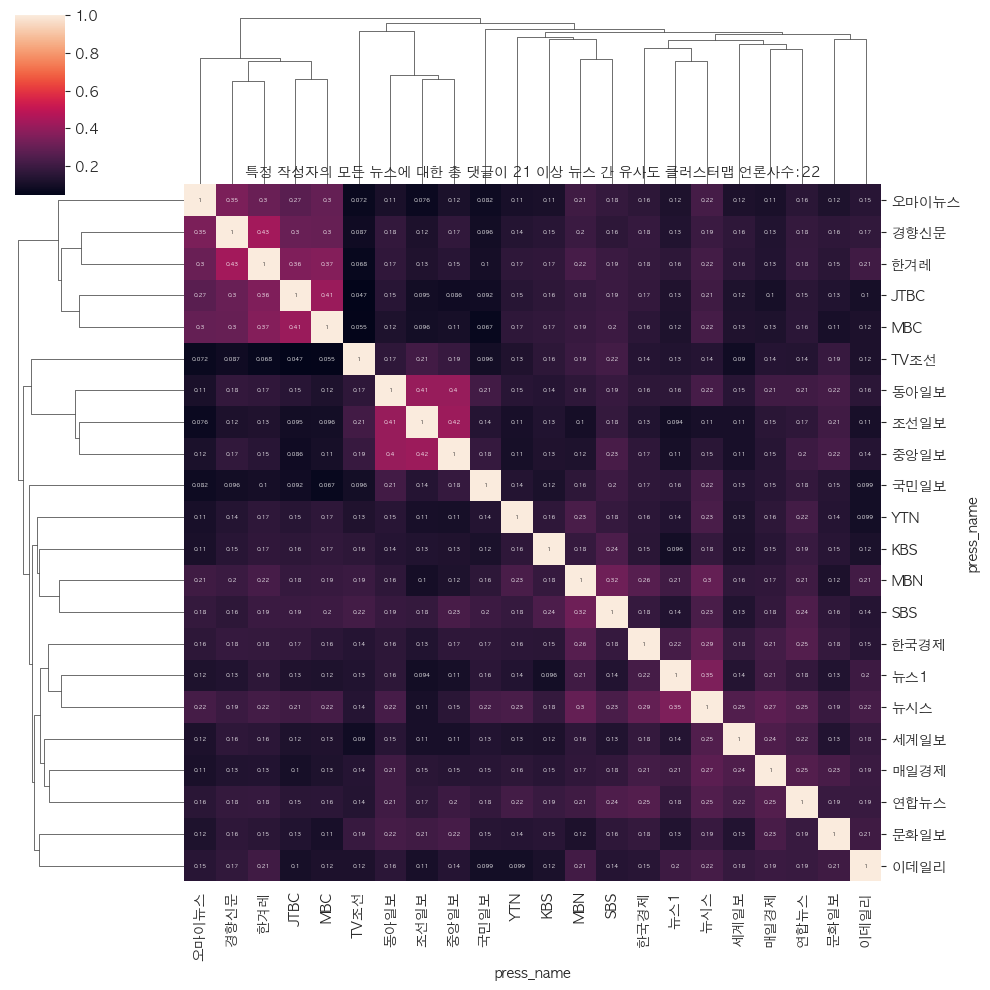

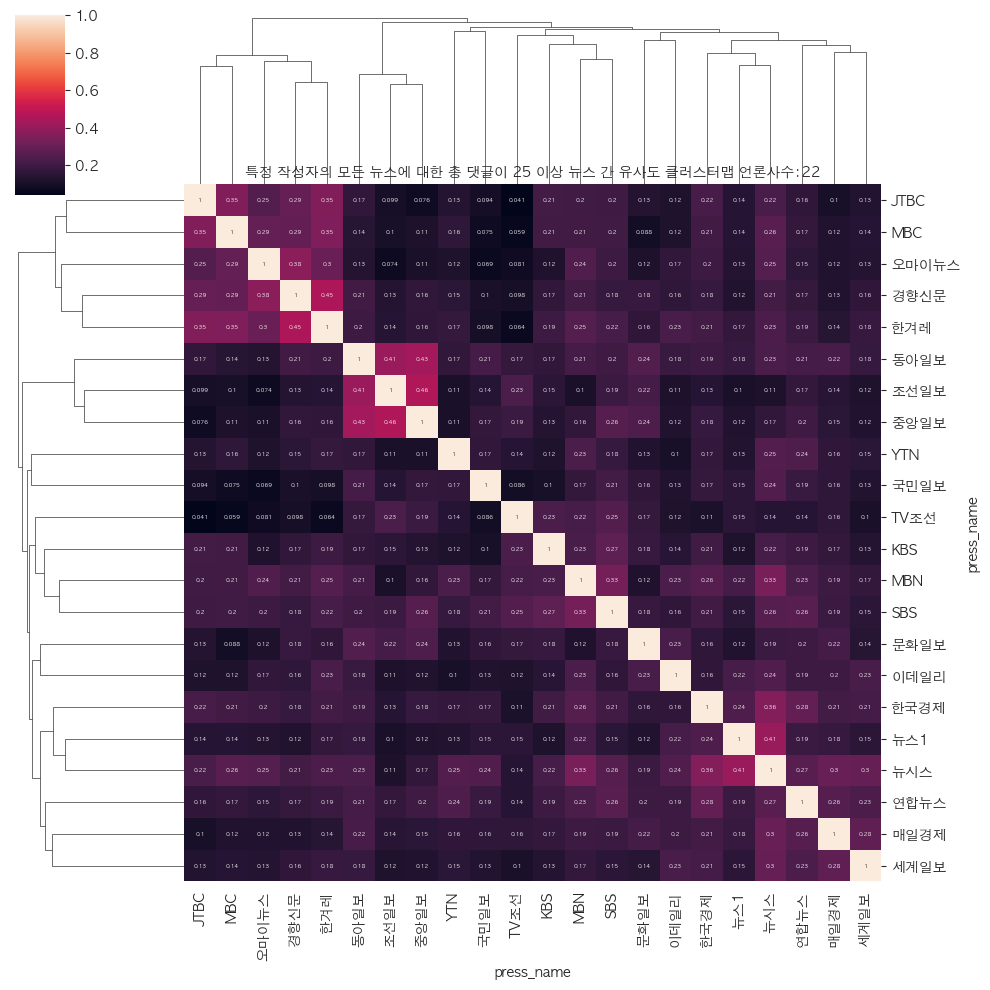

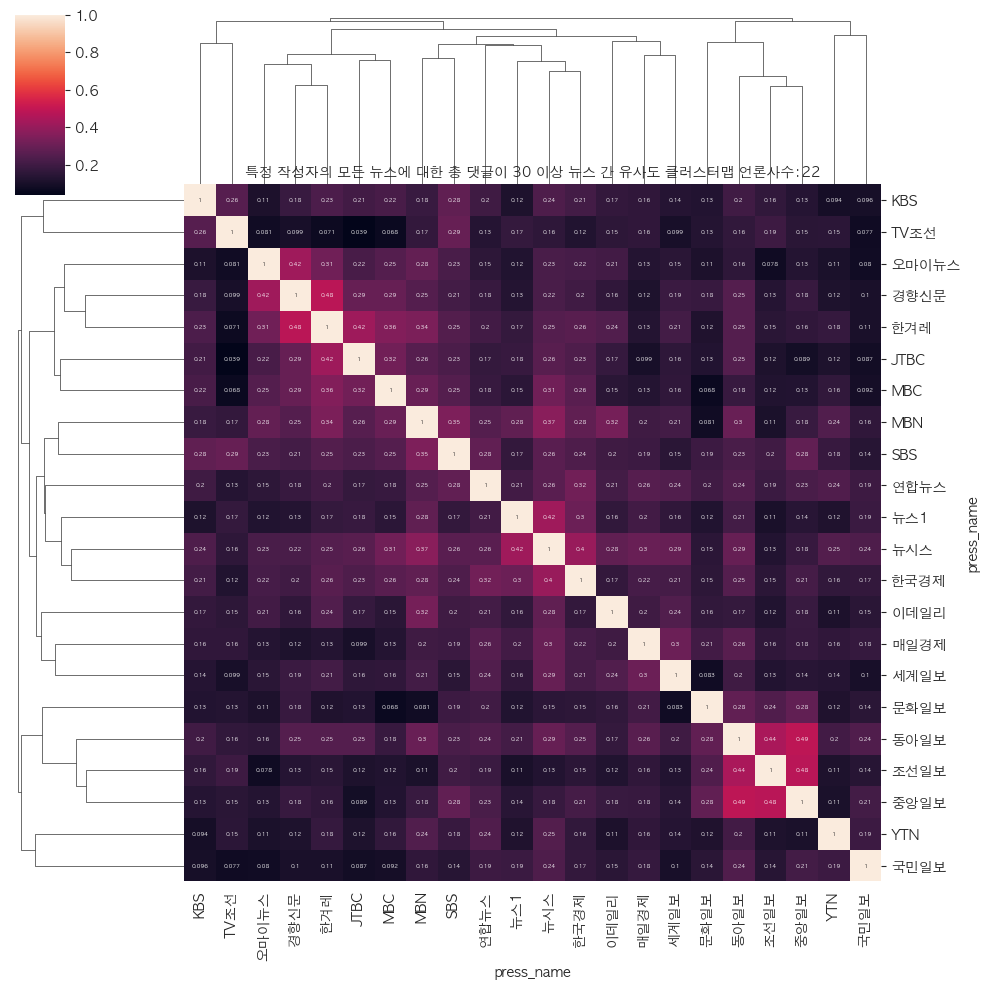

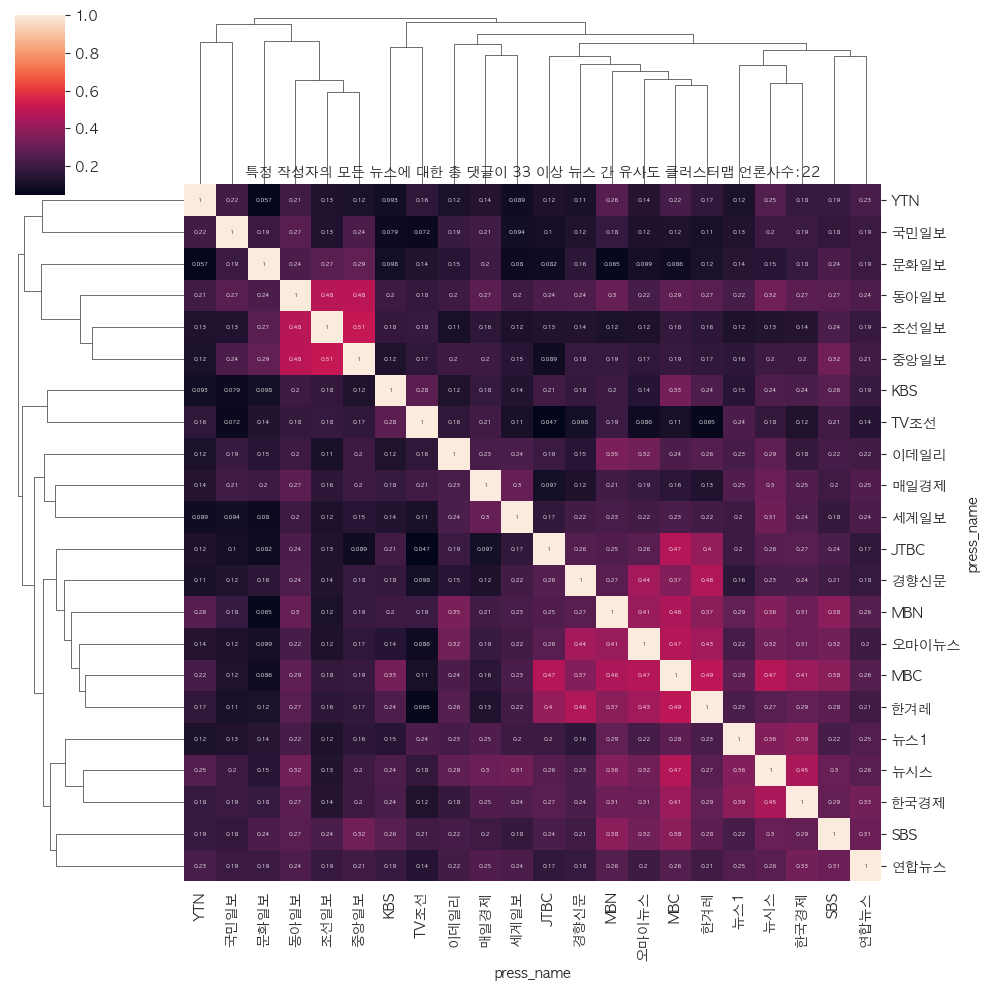

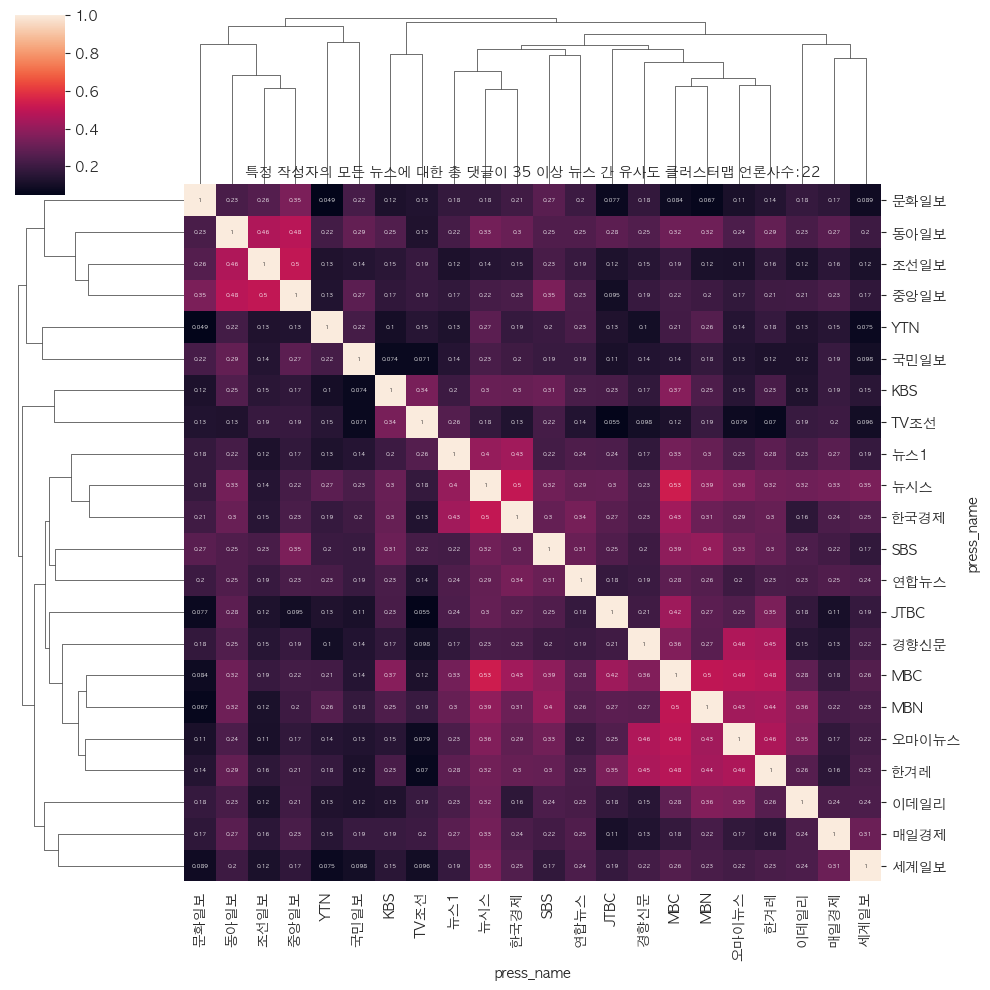

In [56]:

for i in  [3,5,8,13,21,25,30,33,35]:

    df_pivot3 = df_pivot[df_pivot.sum(axis=1) > i]
    total_press_counts= len(df_pivot3.columns)
    similarity_matrix = pd.DataFrame(
    cosine_similarity(df_pivot3.T),
    index=df_pivot3.columns,
    columns=df_pivot3.columns
    )
    font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    font_name = font_prop.get_name()

    plt.rcParams['font.family'] = font_name
    labels = df_pivot3.columns
    labels = [unicodedata.normalize('NFC', label) for label in labels]
    cluster = sns.clustermap(similarity_matrix, cmap="rocket", annot=True,annot_kws={"size": 4}, figsize=(10, 10),xticklabels=labels, yticklabels=labels)
    cluster.ax_heatmap.set_title(f"특정 작성자의 모든 뉴스에 대한 총 댓글이 {i} 이상 뉴스 간 유사도 클러스터맵 언론사수:{total_press_counts}", fontproperties=font_prop)

    plt.show()


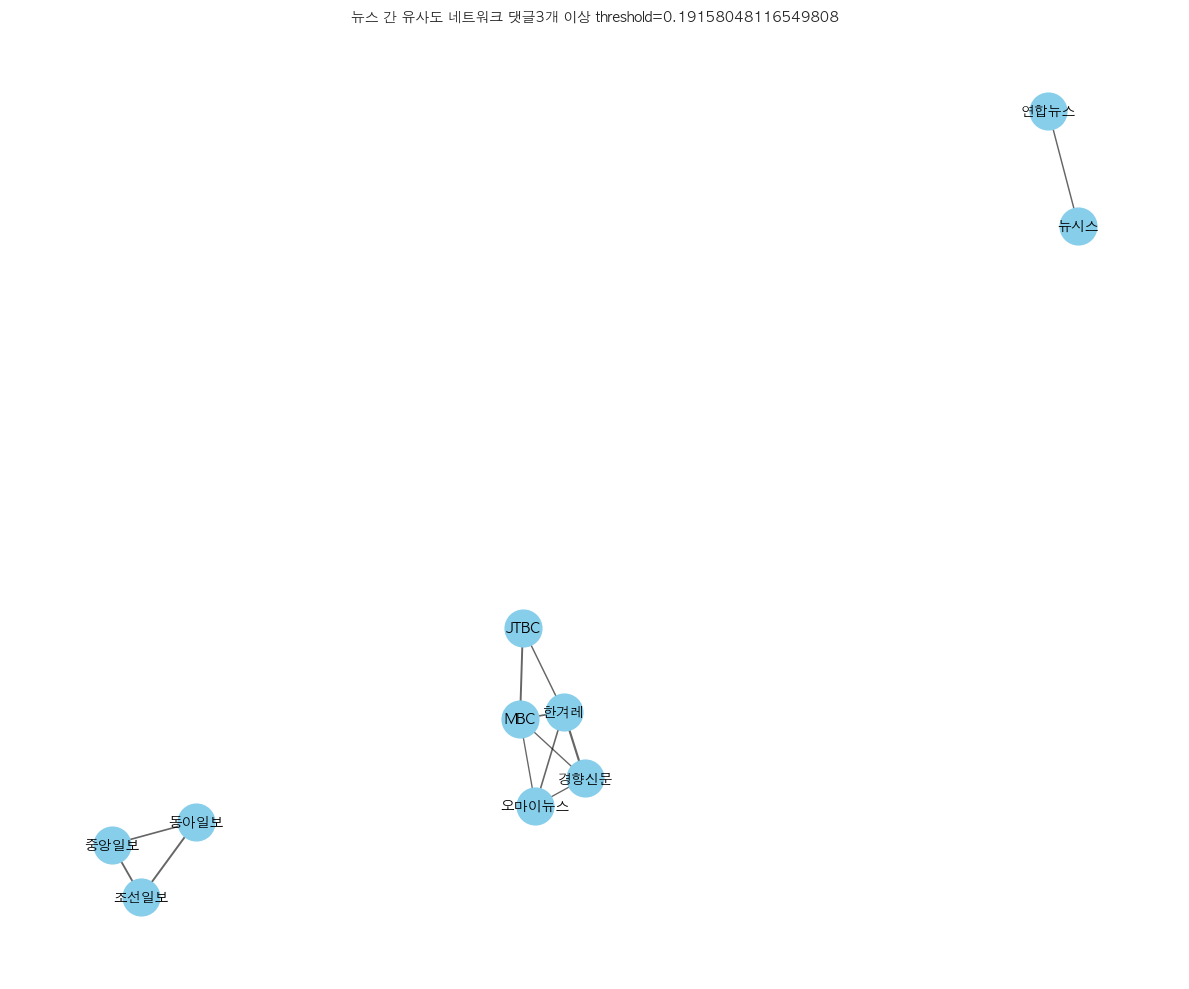

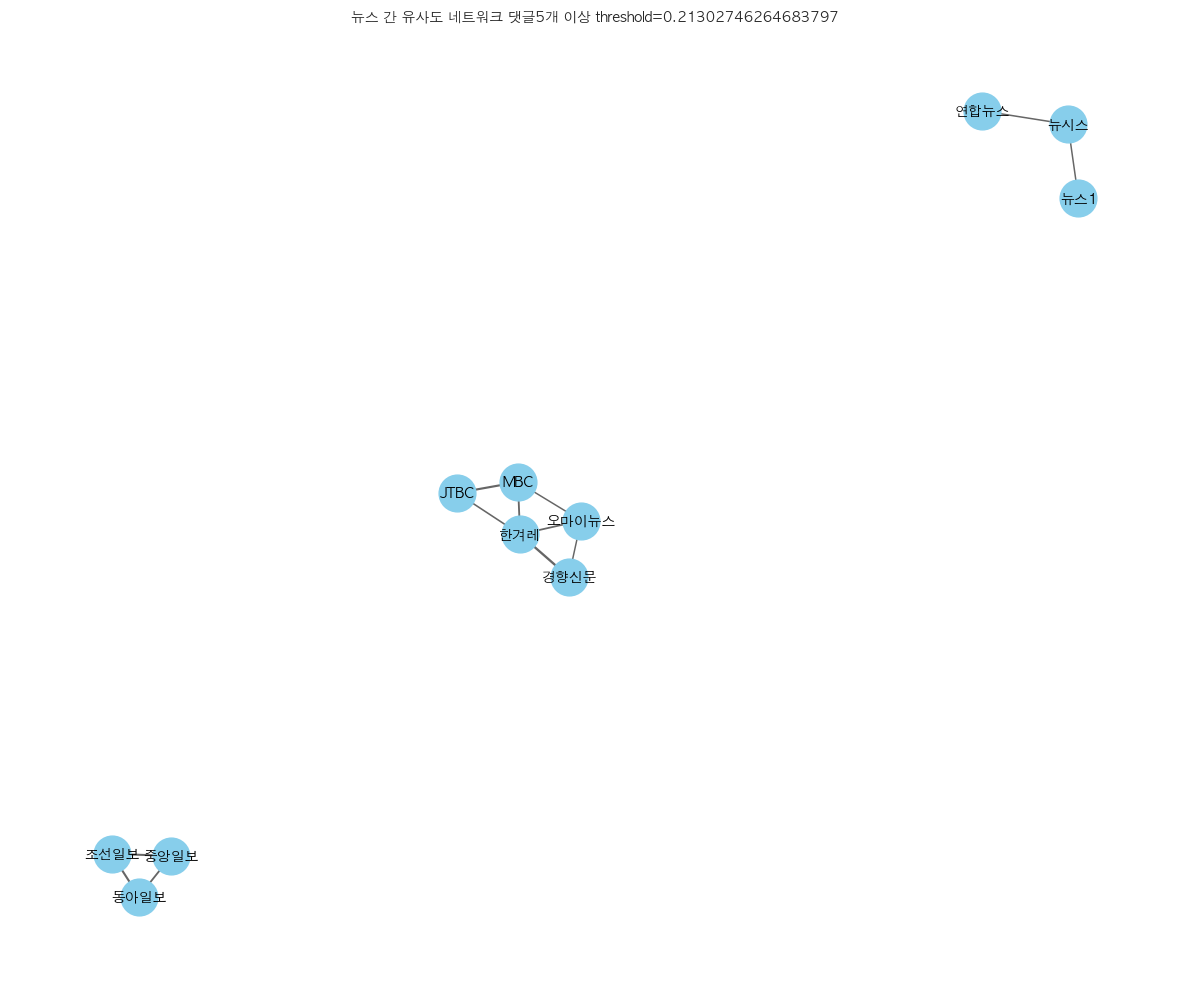

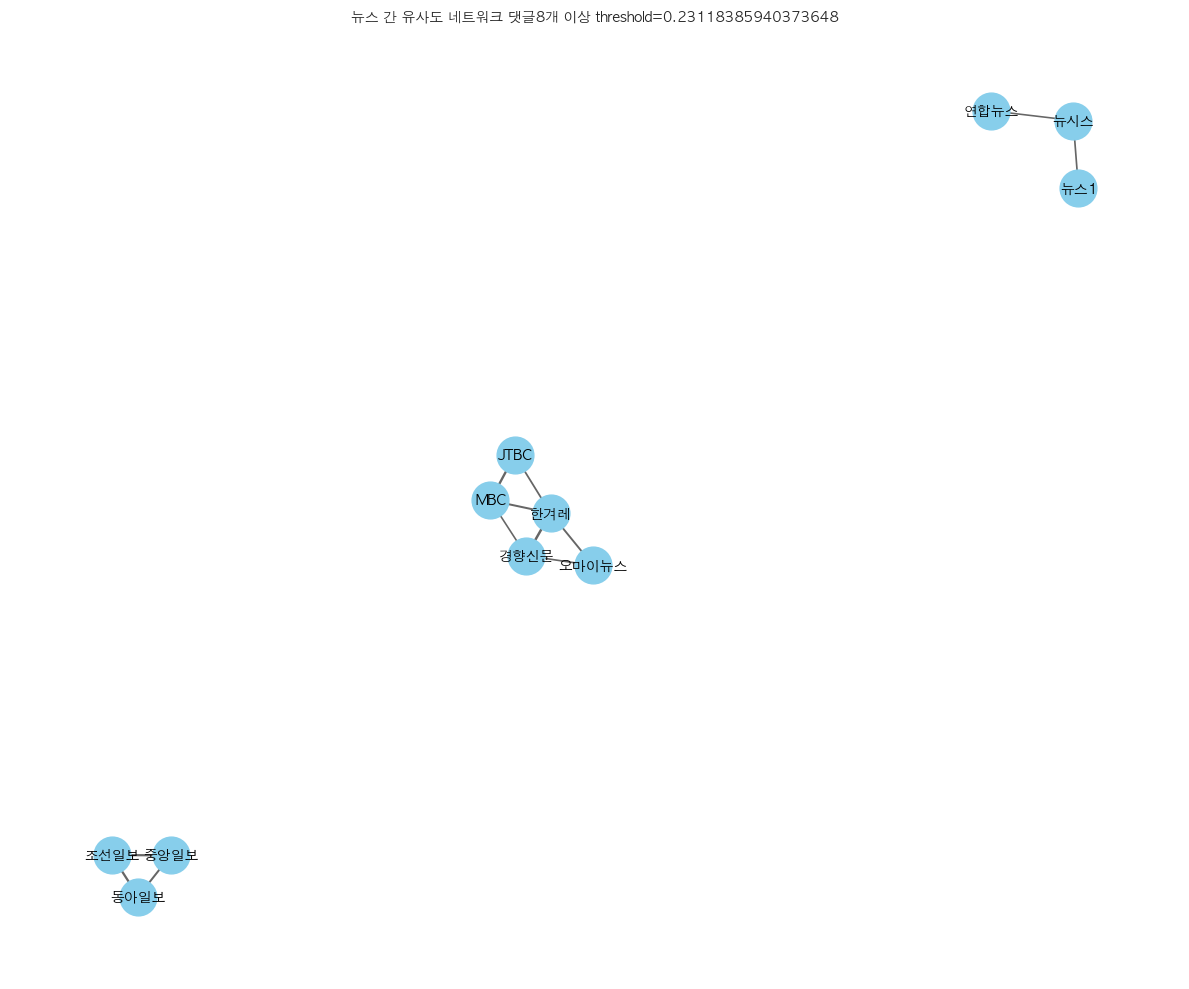

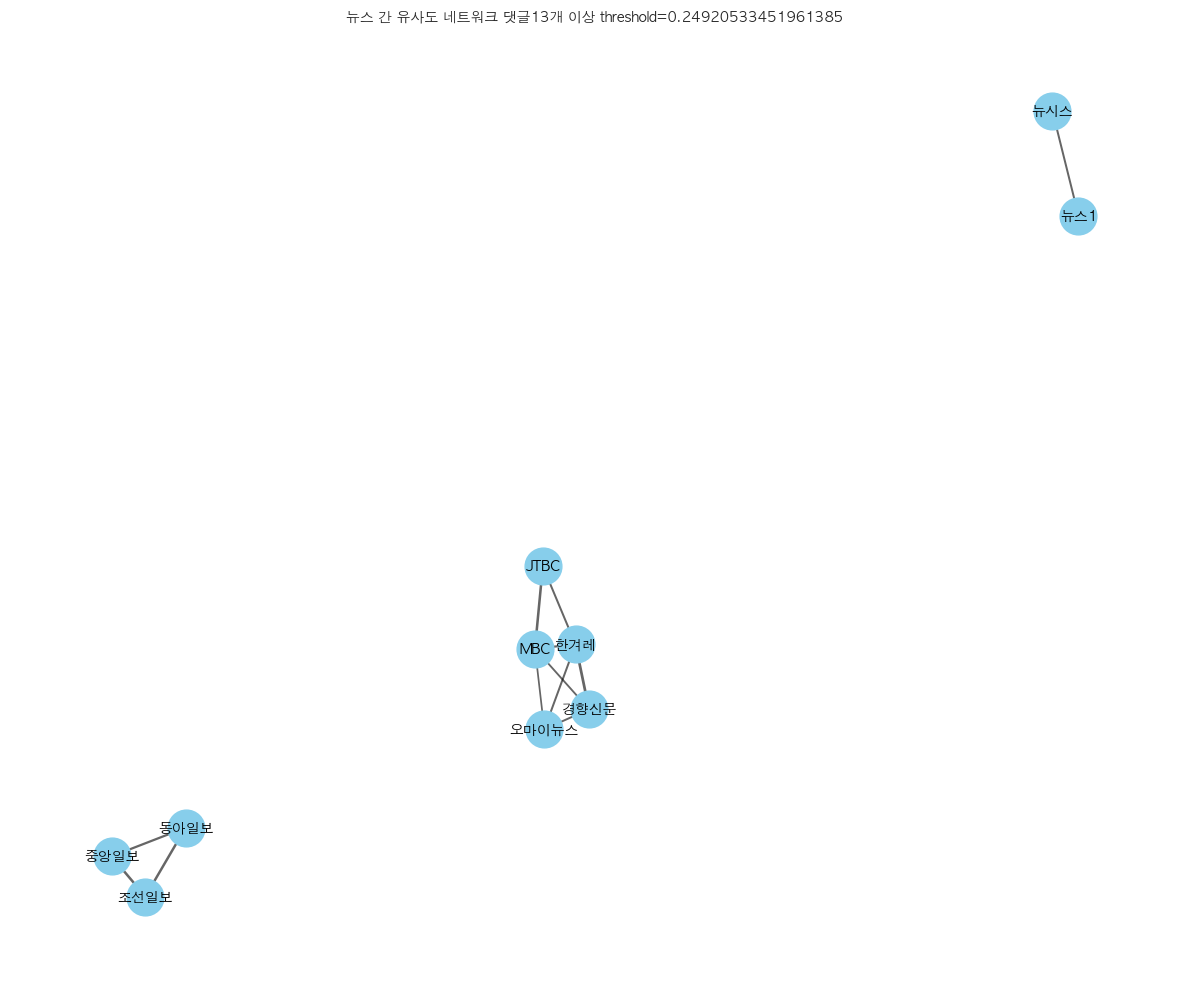

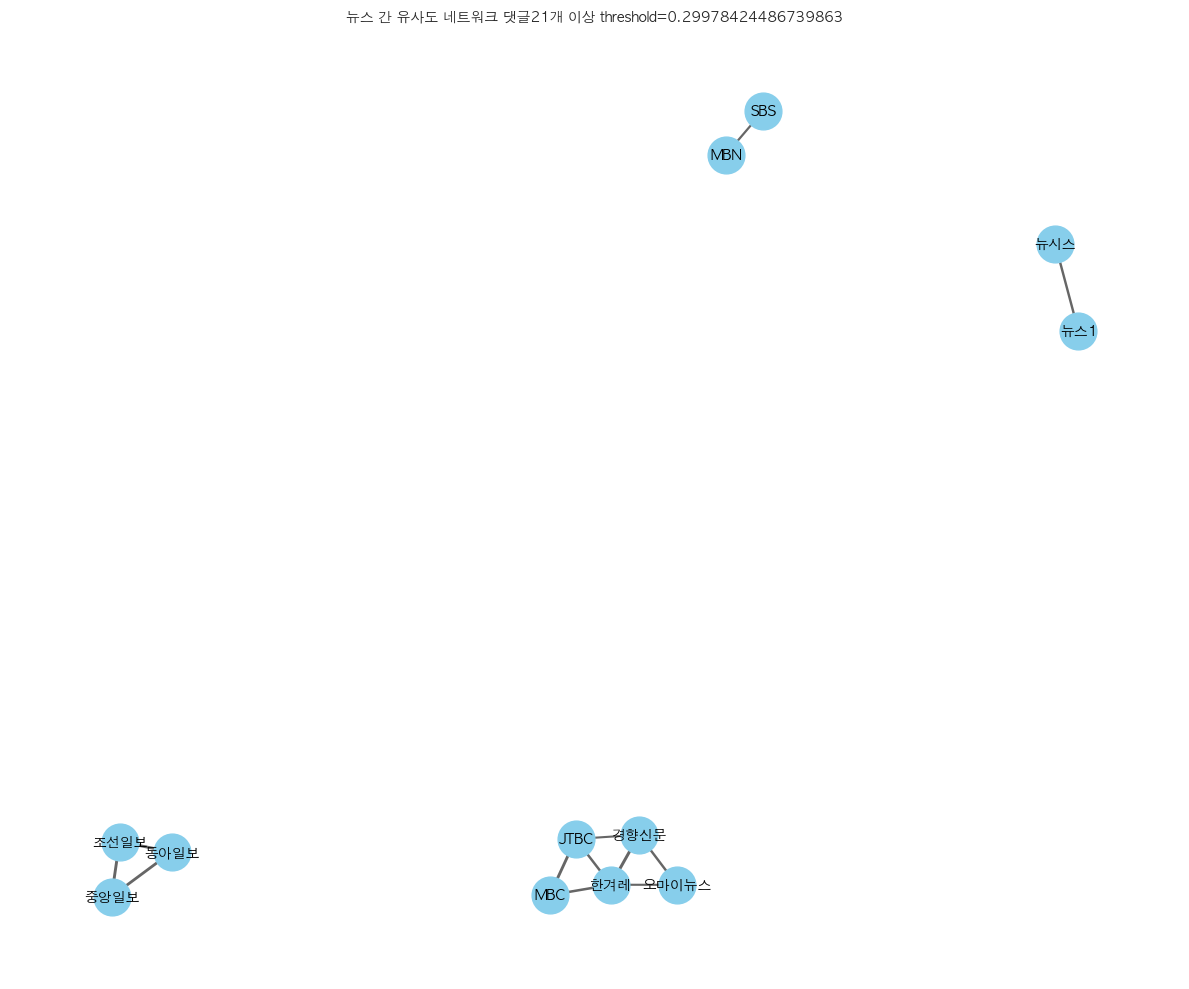

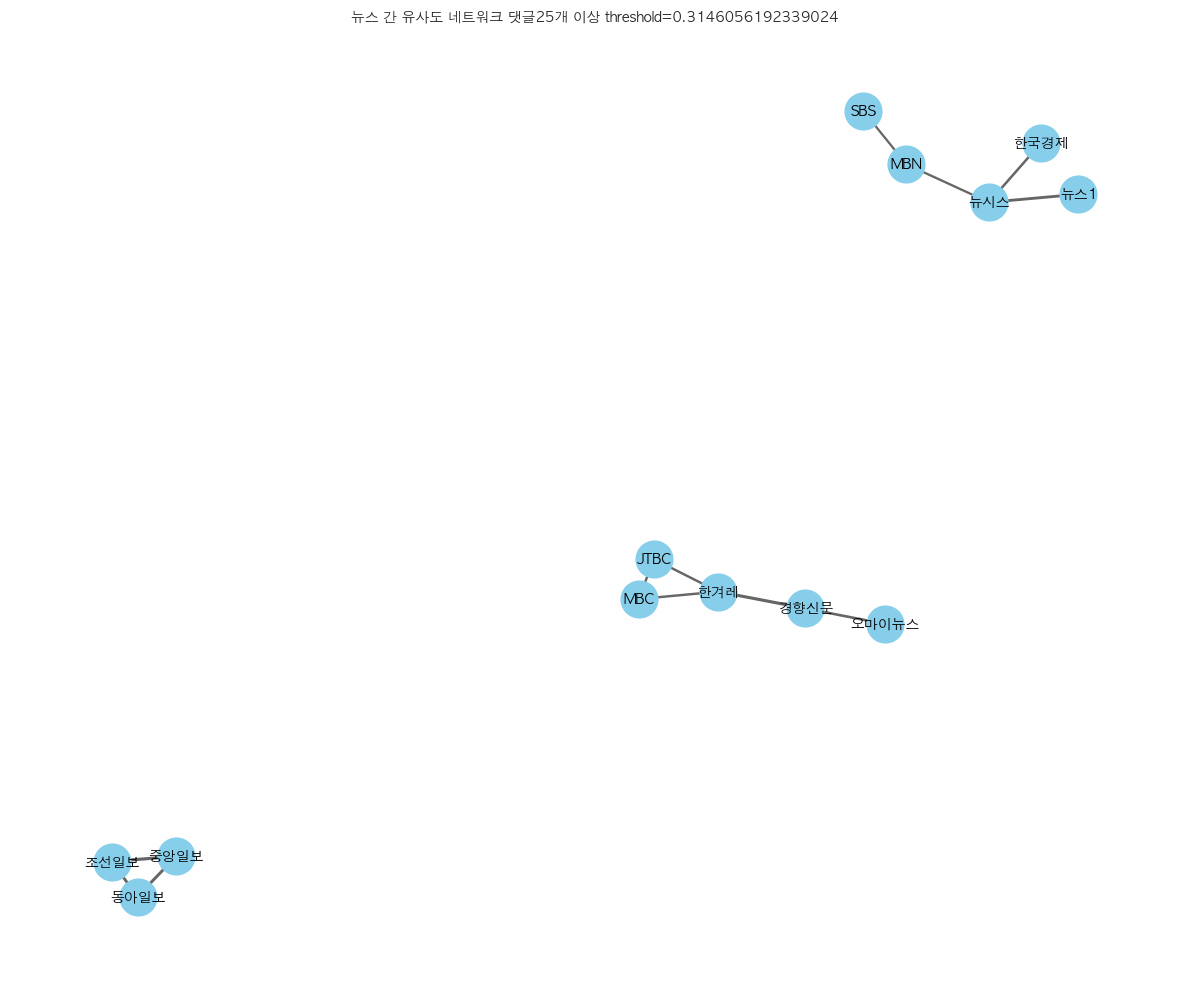

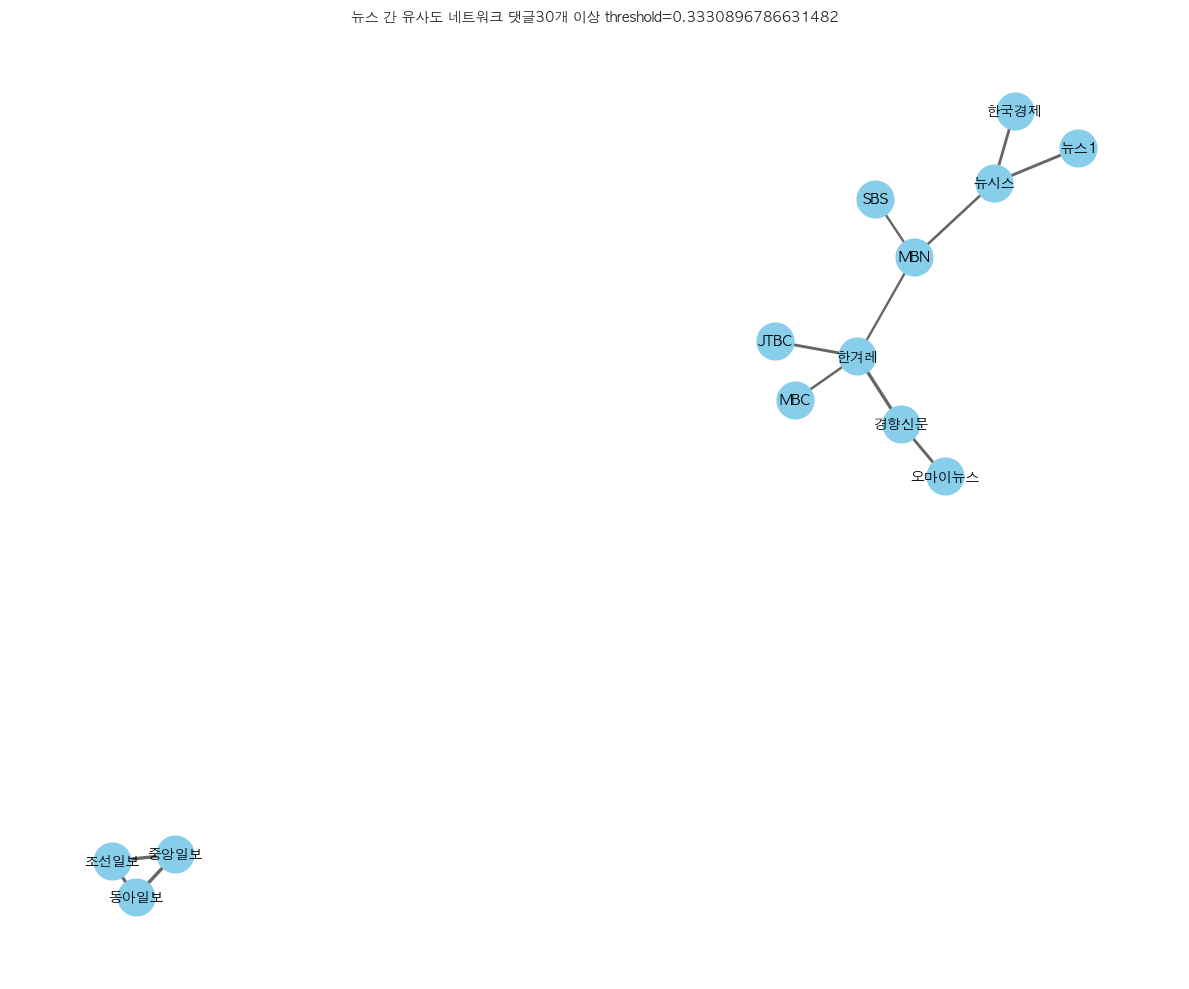

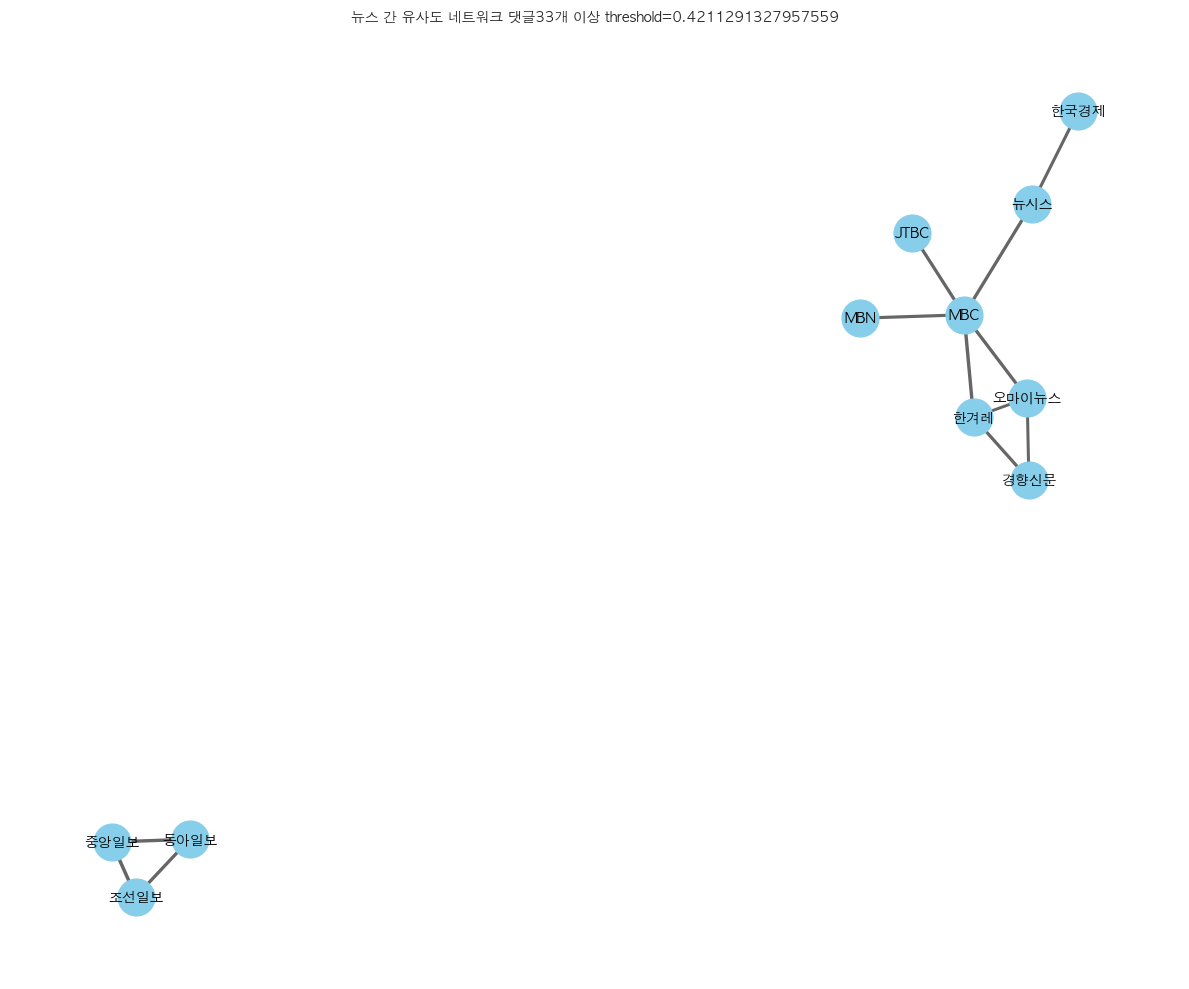

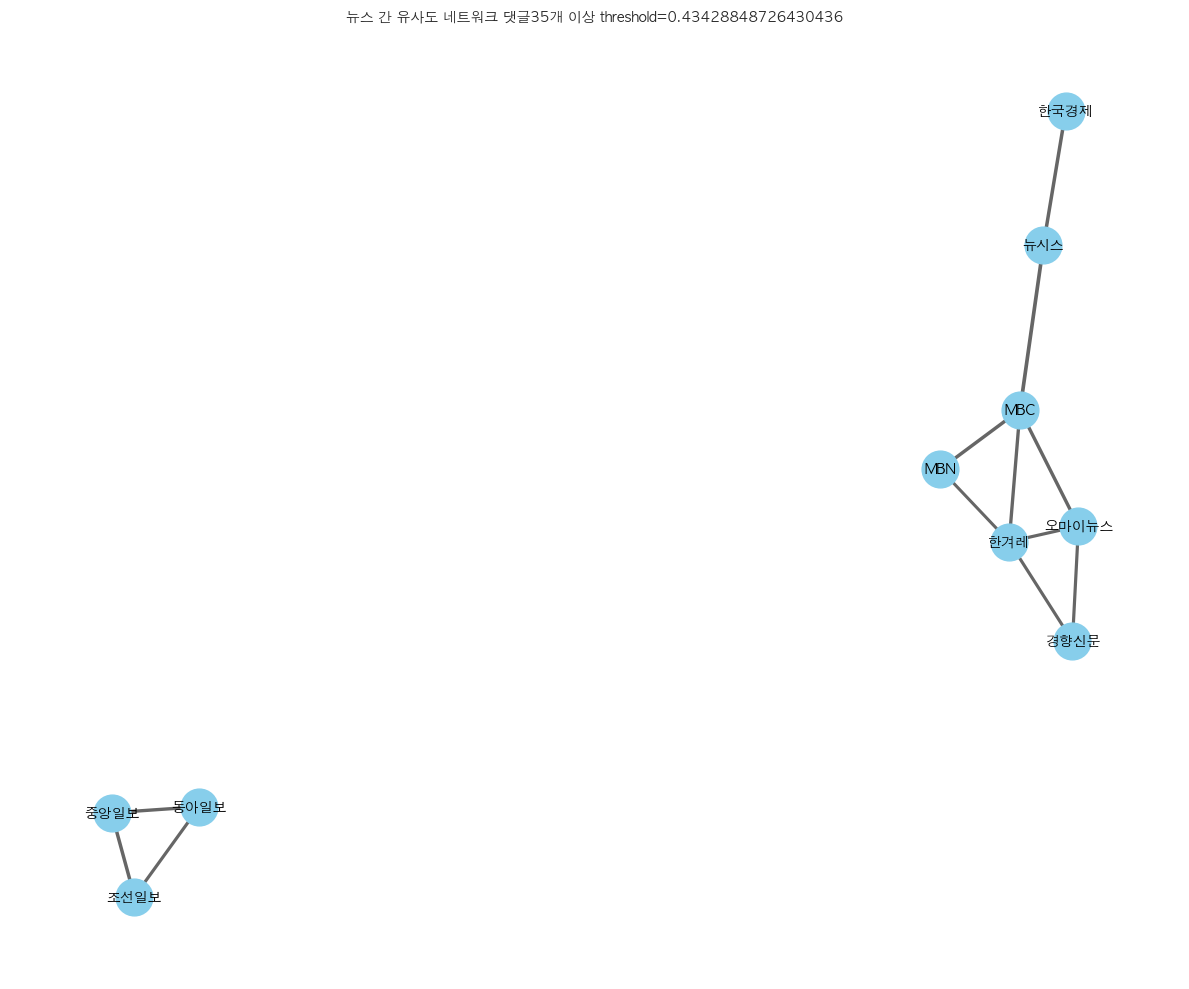

In [58]:

for s in [3,5,8,13,21,25,30,33,35]:

    df_pivot3 = df_pivot[df_pivot.sum(axis=1) > s]
    news_vectors = df_pivot3.T

# 유사도 행렬 계산
    similarity = cosine_similarity(news_vectors)
    similarity_df = pd.DataFrame(similarity, index=news_vectors.index, columns=news_vectors.index)
    G = nx.Graph()

    # threshold = min(0.2 + (s / 60) ** 3, 0.6) # 유사도 기준 설정
    threshold = np.percentile(
    similarity_df.values[np.triu_indices_from(similarity_df, k=1)],95)

    labels = df_pivot3.columns
    labels = [unicodedata.normalize('NFC', label) for label in labels]

    for press in labels:
        G.add_node(press)

    # 엣지 추가 (유사도 기반)
    for i in similarity_df.columns:
        for j in similarity_df.columns:
            if i != j and similarity_df.loc[i, j] >= threshold:
                G.add_edge(i, j, weight=similarity_df.loc[i, j])


    # 1. AppleGothic 폰트 설정
    font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    font_name = font_prop.get_name()

    # 2. 전역 설정 (안 해도 되지만, 혹시 모르니 함께 설정)
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False

    # 3. 네트워크 그리기
    plt.figure(figsize=(12, 10))

    pos = nx.spring_layout(G, seed=42)

    edges = G.edges(data=True)
    weights = [d['weight']*5 for (_, _, d) in edges]
    G.remove_nodes_from(list(nx.isolates(G)))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=weights, edge_color="black",alpha=0.6)
    nx.draw_networkx_labels(G, pos, labels={n: unicodedata.normalize('NFC', n) for n in G.nodes()},
                            font_size=10, font_family=font_name)

    plt.title(f"뉴스 간 유사도 네트워크 댓글{s}개 이상 threshold={threshold}", fontproperties=font_prop)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


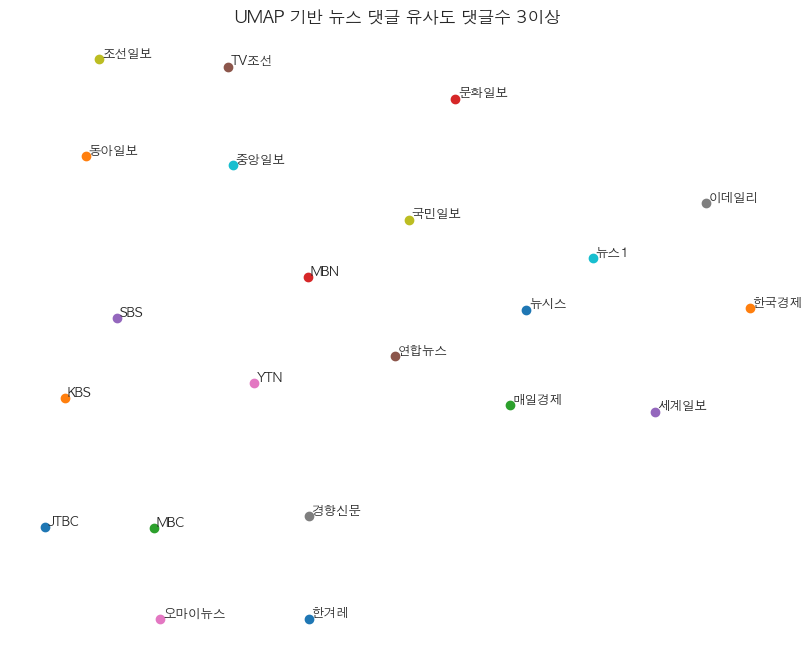

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


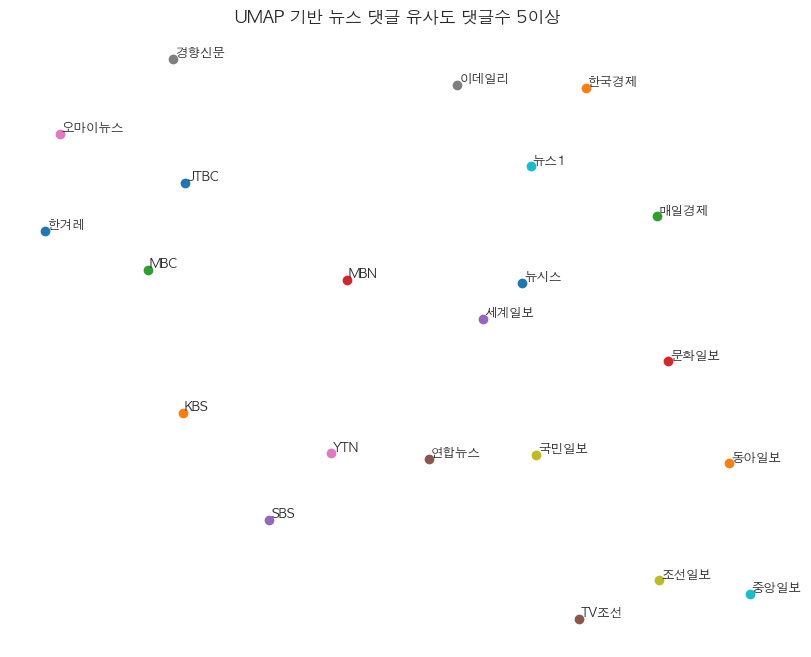

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


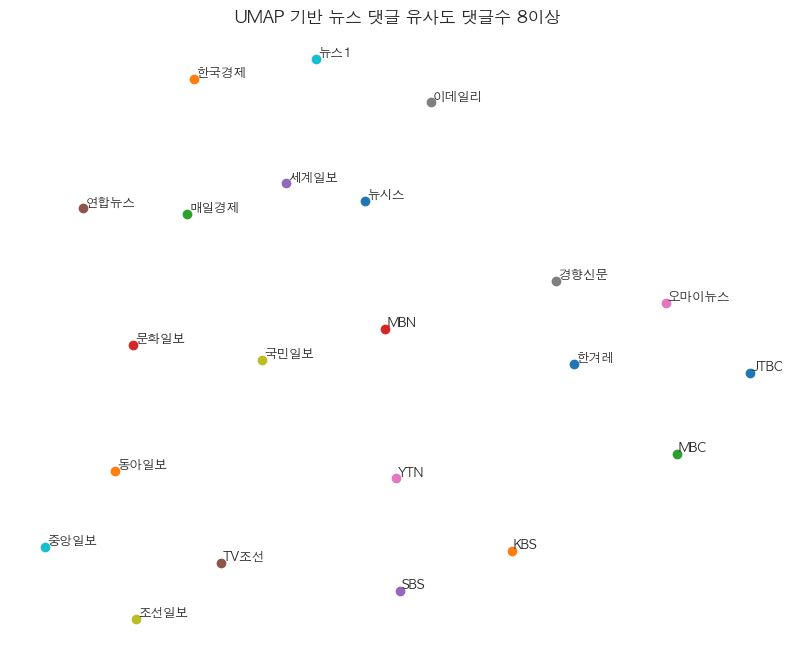

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


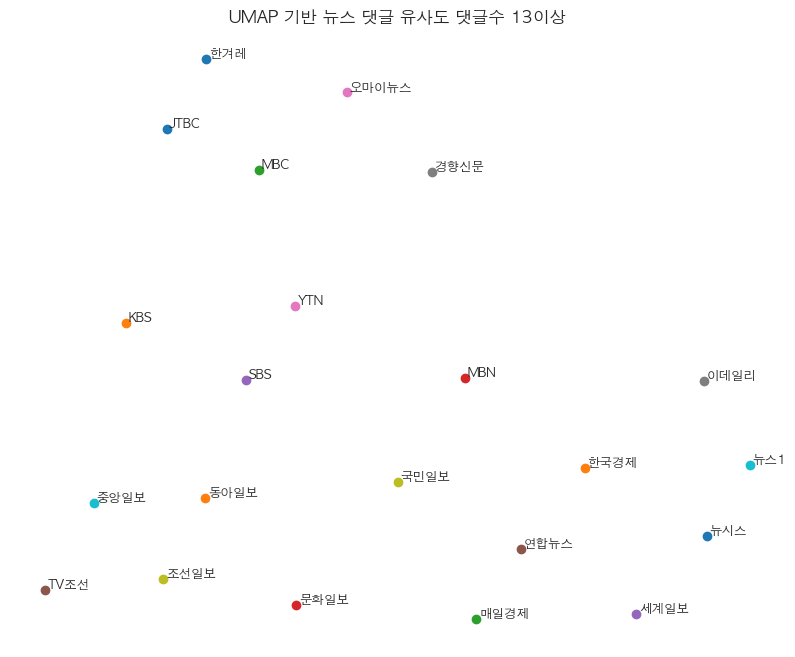

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


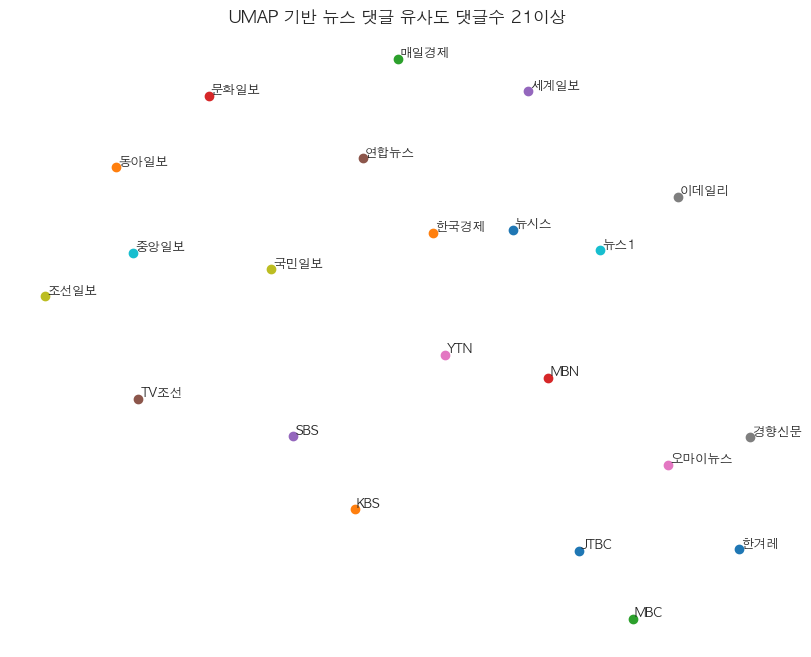

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


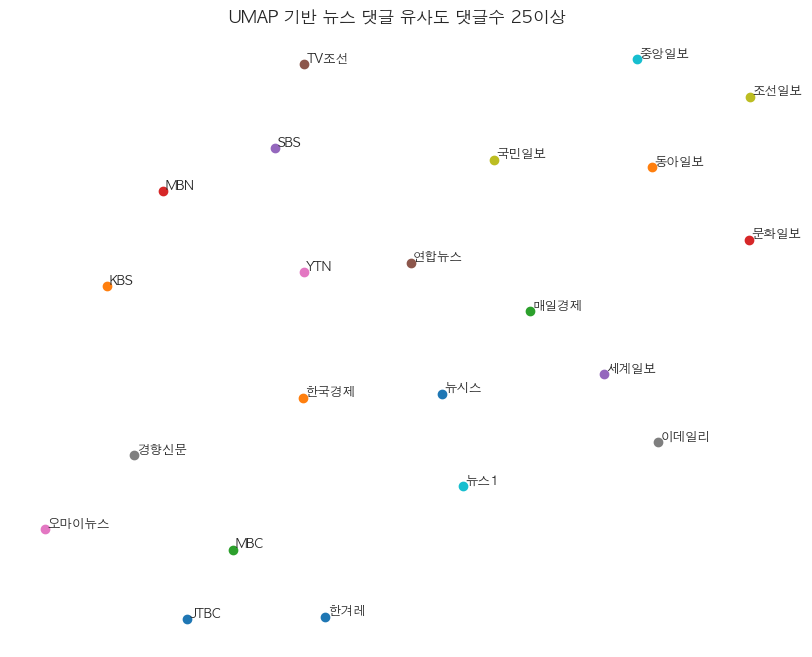

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


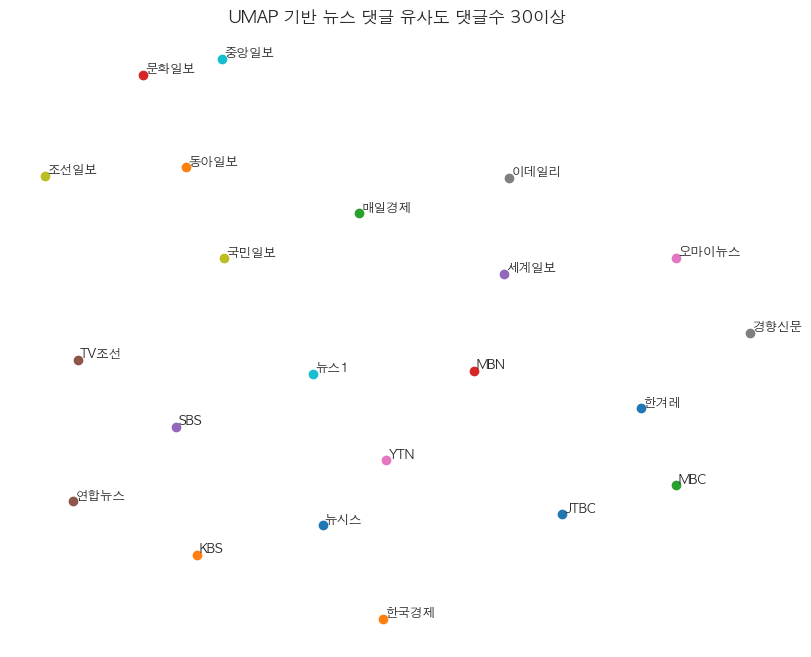

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


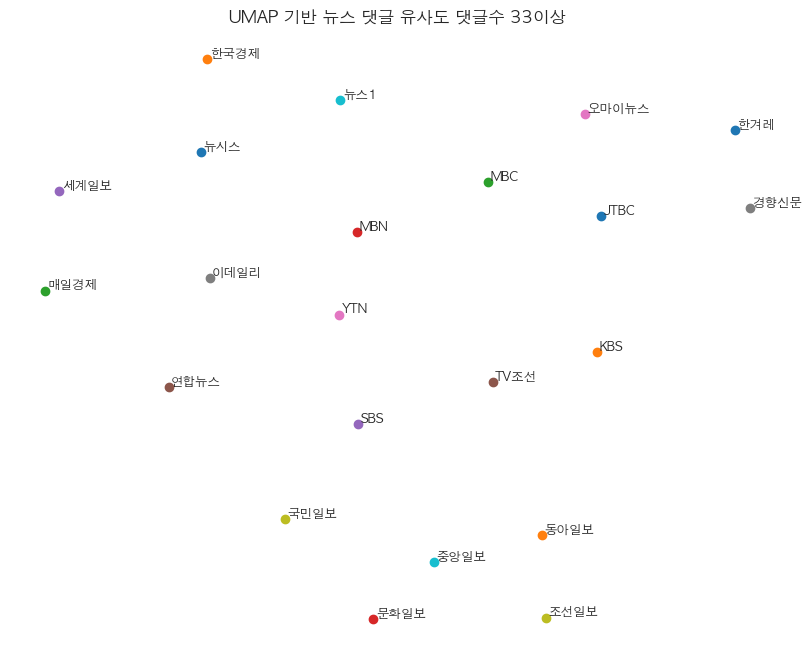

/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


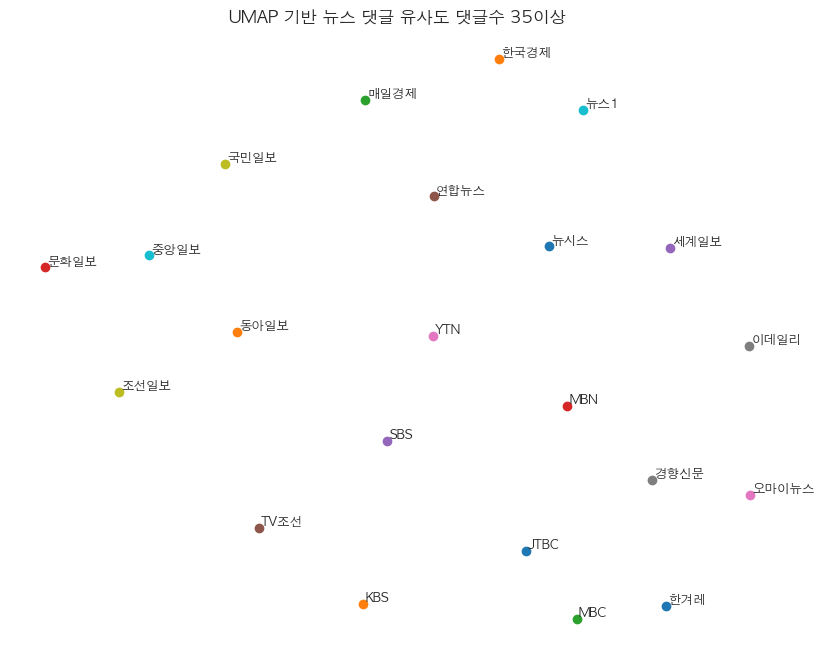

In [57]:
from umap import UMAP
for s in [3,5,8,13,21,25,30,33,35]:

    df_pivot3 = df_pivot[df_pivot.sum(axis=1) > s]
    news_vectors = df_pivot3.T
    reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
    embedding = reducer.fit_transform(news_vectors)

    # 라벨 정리
    labels = [unicodedata.normalize('NFC', label) for label in news_vectors.index]

    # 시각화
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        plt.scatter(embedding[i, 0], embedding[i, 1])
        plt.text(embedding[i, 0]+0.01, embedding[i, 1]+0.01, label, fontsize=9)

    plt.title(f"UMAP 기반 뉴스 댓글 유사도 댓글수 {s}이상")
    plt.xticks([]); plt.yticks([]); plt.box(False)
    plt.show()

In [36]:
df_pivot3 = df_pivot[df_pivot.sum(axis=1) > 25]
news_vectors=df_pivot3.T
news_vectors

userIdNo,102ez,108Mw,11dMy,12Ajo,12jgh,13GH6,13NRG,13NUx,13kiW,14HRk,...,wDqI,wRku,wdXH,wePh,xLKI,xk2n,yPFU,yktA,z9oI,zrQT
press_name,,,,,,,,,,,,,,,,,,,,,
JTBC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
KBS,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
MBC,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,3.0,1.0,0.0,9.0,0.0,0.0,4.0,0.0,0.0,0.0
MBN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
SBS,0.0,0.0,0.0,0.0,1.0,1.0,4.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
TV조선,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,3.0,0.0
YTN,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0
경향신문,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,...,1.0,1.0,2.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0
국민일보,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


25


/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


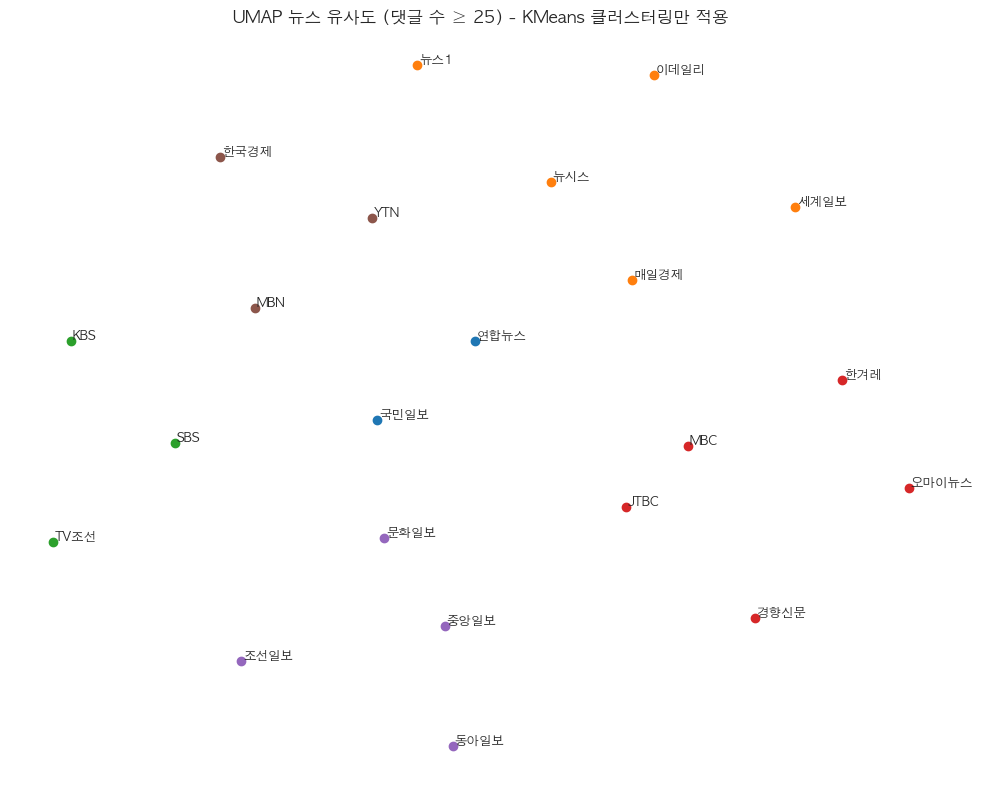

In [61]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
import unicodedata

for s in [25]:
    print(s)
    df_pivot3 = df_pivot[df_pivot.sum(axis=1) > s]
    news_vectors = df_pivot3.T
    reducer = umap.UMAP(
    n_components=2,
    metric='cosine',
    n_neighbors=50,      # 작게
    min_dist=1,       # 멀게
    random_state=42
)
    embedding = reducer.fit_transform(news_vectors)
    labels = [unicodedata.normalize('NFC', label) for label in news_vectors.index]

    # 클러스터링
    n_clusters = min(6, len(embedding))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)
    colors = plt.cm.tab10(cluster_labels)

    # 시각화
    plt.figure(figsize=(10, 8))
    for i, (x, y) in enumerate(embedding):
        plt.scatter(x, y, color=colors[i])
        plt.text(x + 0.01, y + 0.01, labels[i], fontsize=9)

    plt.title(f"UMAP 뉴스 유사도 (댓글 수 ≥ {s}) - KMeans 클러스터링만 적용")
    plt.xticks([]); plt.yticks([]); plt.box(False)
    plt.tight_layout()
    plt.show()

25


/Users/jeongseonghyeon/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


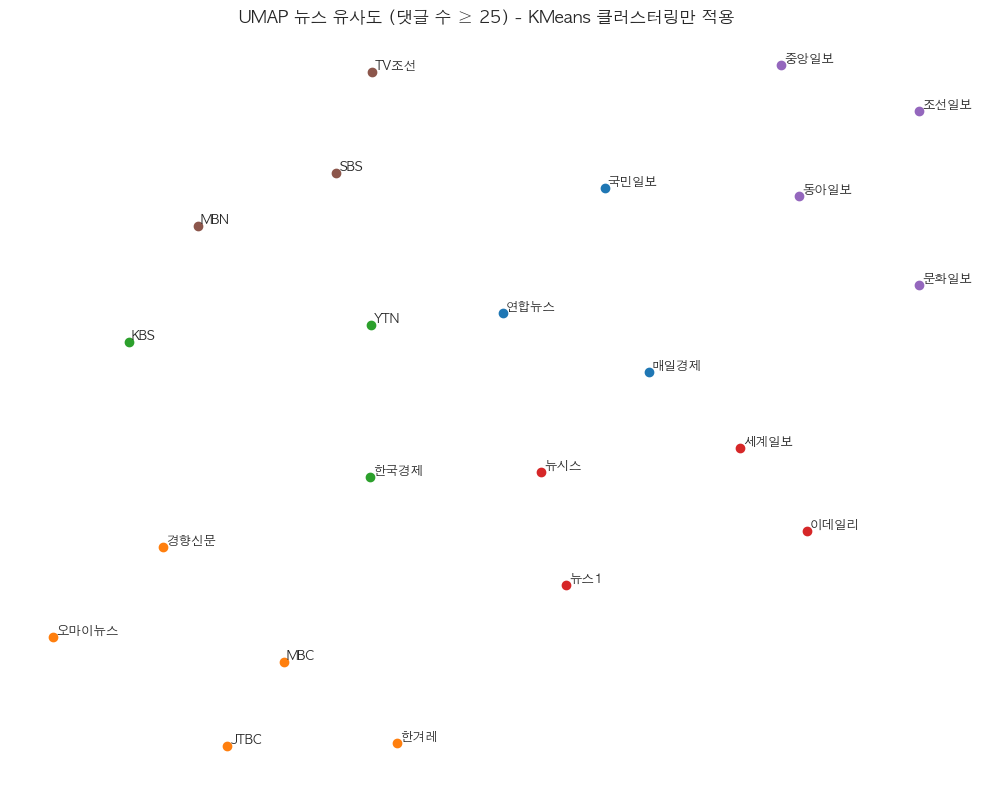

In [54]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
import unicodedata

for s in [25]:
    print(s)
    df_pivot3 = df_pivot[df_pivot.sum(axis=1) > s]
    news_vectors = df_pivot3.T
    reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
    embedding = reducer.fit_transform(news_vectors)
    labels = [unicodedata.normalize('NFC', label) for label in news_vectors.index]

    # 클러스터링
    n_clusters = min(6, len(embedding))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)
    colors = plt.cm.tab10(cluster_labels)

    # 시각화
    plt.figure(figsize=(10, 8))
    for i, (x, y) in enumerate(embedding):
        plt.scatter(x, y, color=colors[i])
        plt.text(x + 0.01, y + 0.01, labels[i], fontsize=9)

    plt.title(f"UMAP 뉴스 유사도 (댓글 수 ≥ {s}) - KMeans 클러스터링만 적용")
    plt.xticks([]); plt.yticks([]); plt.box(False)
    plt.tight_layout()
    plt.show()